# Generation of results for the simulation of semi-automated title-abstract screening for systematic reviews of prognosis and intervention studies

Isa Spiero <br>

#### Part I: Set-up
- **1. Import the packages and functions**
- **2. Import the intervention and prognsos review datasets** <br>

#### Part II: Simulations with original review datasets 
- **3. Retrieve and merge the output from all simulations** 
<br>The simulations based on the imported datasets were previously run with a seperate code on a High Performance Computer (HPC). The simulations were run for variations of: the 6 prognosis and 6 intervention review datasets (= 12 datasets + 1 dataset in appendix), 2 feature extraction models + 3 classification models ( = 5 model combinations), and 200 randomly sampled initial training data. This resulted in 13\*5*200 = 13000 simulations stored in the same number of pickle files (.p). Each of these files consists of a ranking from simulating the semi-automated screening with the respective dataset and modeling methods. All these files are loaded and the output stored for futher processing.
- **4. Compute performance metrics from the retrieved simulation output**
<br>The retrieved output is then used to calculate the performance metrics (recall, precision at 95% recall, WSS at 95% recall, and nWSS at 95% recall) for each of the simulations.
- **5. Create raw tables with all performance metrics seperately** 
- **6. Process raw tables into pooled tabels (for results)**
- **7. Create histograms for WSS and precision (for results)** 
- **8. Create boxplots/lineplots of increasing recall during screening (for results)** <br>

#### Part III: Simulations with adapted review datasets 
- **9. Variations in number of (relevant) records**
- **10. Retrieve and merge the output from all simulations**
The simulations using the manually adapted datasets were previously run with a seperate code on a High Performance Computer (HPC). The simulations were run for variations of: the 4 prognosis and 4 intervention datasets manually adapted to contain 2000, 1000, and 500 records of which 50 inclusions ( = 24 manually adapted datasets), 5 samples (seeds) for each manually adapted dataset, 1 feature extraction model + 1 classification model (default models), and 200 randomly sampled initial training data. This resulted in 24\*5*200 = 24000 simulations stored in the same number of pickle files (.p). Each of these files consists of a ranking from simulating the semi-automated screening with the respective dataset and sampling seed. All these files are loaded and the output stored for futher processing.
- **11. Compute performance metrics from the retrieved simulation output**
<br>The retrieved output is then used to calculate the performance metrics (recall, precision at 95% recall, WSS at 95% recall, and nWSS at 95% recall) for each of the simulations.
- **12. Create raw tables with all performance metrics seperately**
- **13. Process raw tables into pooled tables (for results)**
- **14. Create histograms for WSS and precision (for results)**
- **15. Create lineplots of increasing recall during screening (for results)**

## Part I: Set-up

### 1. Import the packages and functions

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import pickle
import os
import shutil
import math
import seaborn as sns
import matplotlib.pyplot as plt
import argparse
import collections

In [2]:
from functions import compute_metrics
from functions import generate_recall_table_prop, max_recall_prop
from functions import generate_wss_table, generate_results_table

In [3]:
from asreview.models.classifiers import LogisticClassifier, LSTMBaseClassifier, LSTMPoolClassifier, NaiveBayesClassifier, NN2LayerClassifier, RandomForestClassifier, SVMClassifier
from asreview.models.query import ClusterQuery, MaxQuery, MaxRandomQuery, MaxUncertaintyQuery, RandomQuery, UncertaintyQuery
from asreview.models.balance import DoubleBalance, SimpleBalance, UndersampleBalance
from asreview.models.feature_extraction import Doc2Vec, EmbeddingIdf, EmbeddingLSTM, SBERT, Tfidf
from asreview import open_state

from pathlib import Path

In [4]:
import os
os.chdir("..")
os.getcwd()

'/Users/ispiero2/Documents/Research/Scripts/Study - Semi-automated screening for SR/GitHub version'

In [5]:
# TODO change data files to .csv

path_data = 'data/' 
path_results_HPC = 'output/simulations_original_datasets/'
path_results = 'results/' 

### 2. Import the intervention and prognosis review datasets

The intervention review datasets that were used for simulation are imported (numbering of the datasets is ordered by authors), and the prognosis review datasets that were used for simulation are imported (numbering of the datasets is ordered by author, so numbers do not correspond to numbers in data prep):

In [6]:
# Load all the review datasets from the dataset-containing folder into a dictionary
review_dic = {}

for file_name in os.listdir(path_data):
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(path_data, file_name)
        df = pd.read_excel(file_path)
        key = os.path.splitext(file_name)[0].split("_")[0]
        review_dic[key] = df

review_dic = dict(sorted(review_dic.items()))

In [7]:
# Create separate dictionaries for intervention and prognosis review datasets
dfs_int = {key: value for key, value in review_dic.items() if key.startswith('Int')}
dfs_prog = {key: value for key, value in review_dic.items() if key.startswith('Prog')}

## Part II: Simulations with original review datasets

### 3. Retrieve and merge the output from all simulations

To assess the performance of the semi-automated screening tool, not only the reviews, but also the classification models, feature extraction models, and/or query models were varied in the simulations:

In [8]:
# Specify the the classification, feature extraction, and query model(s) that were tested
train_models = [LogisticClassifier(), NaiveBayesClassifier(), SVMClassifier()] 
feature_models = [Tfidf(), SBERT()] 
query_models = [MaxQuery()]

# Specify the number of simulations per review-model combination  
n_simulations = 200 

All the output from the simulations of these variations (conducted on the HPC) can then be retrieved and merged as follows:

In [9]:
# Create a list of the review-model combination names
sim_list_names = []
for review in review_dic:
    for train_model in train_models:
        for feature_model in feature_models:
            for query_model in query_models:
                review_id = str(review + "_" + train_model.name + "_" + feature_model.name + "_" + query_model.name)
                sim_list_names.append(review_id)
                
# Retrieve the output from the HPC generated pickle files with each having the rankings of a single simulation
multiple_sims = []
for i in range(0, len(sim_list_names)):
    raw_output = {}
    for j in range(1,n_simulations+1):
        if Path(path_results_HPC +'sim_{review_id}_{sim}.p'.format(review_id=sim_list_names[i], sim=j)).is_file():
            with open(path_results_HPC + 'sim_{review_id}_{sim}.p'.format(review_id=sim_list_names[i], sim=j),'rb') as f:
                raw_output.update(pickle.load(f))
    if len(raw_output) > 0:
        multiple_sims.append((sim_list_names[i], len(review_dic[sim_list_names[i].split('_')[0]]), n_simulations, raw_output))

In [10]:
# Save (back-up) the file with the simulation results 
# with open(path_results + 'multiple_sims.p','wb') as f:
#     pickle.dump(multiple_sims, f)

or the output can be directly opened from the already saved file:

In [11]:
# Open the file with the simulation results
with open(path_results + 'multiple_sims.p','rb') as f:
    multiple_sims = pickle.load(f)

### 4. Compute performance metrics from the retrieved simulation output

The proportions (i.e. proportion of records screened) and sample sizes (i.e. the number of records screened) of interest can be defined. These are then used for evaluation of the ranking of the records and to calculate the performance metrics at each of these proportions/sample sizes screened. These calculations may take a while to run, therefore they were previously saved and can also directly be opened.

In [12]:
proportions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
sample_sizes = list(map(int,list(np.linspace(0, 99, 100,retstep = True)[0]))) + list(map(int,list(np.linspace(100, 12400, 124,retstep = True)[0])))

Using these proportions and sizes, the following function can be used to derive the performance metrics of the simulation(s):

In [13]:
# Use the compute_metrics function to compute the metrics from the retrieved simulation output
#raw_output = compute_metrics.compute_metrics(multiple_sims, proportions, sample_sizes)

In [14]:
# Save (back-up) a file with the computed output
# with open(path_results + 'sims_output.p','wb') as f:
#     pickle.dump(raw_output, f)

Or directly open the file containing the output (as these especially take a while to run):

In [15]:
# Open the file with the computed output
with open(path_results + 'sims_output.p','rb') as f: #'sims_output_saved_all_final_2okt.p','rb') as f: #'sims_output_saved_all_final_extra.p','rb') as f:
    raw_output = pickle.load(f)

### 5. Create raw tables with all performance metrics seperately

Filter the (for now) relevant parts of the output for the results:

In [16]:
evaluation = {}
for i in range(0, len(raw_output)):
    evaluation[raw_output[i][0]] = []
    evaluation[raw_output[i][0]].append(raw_output[i][3:9])
    
import warnings
warnings.filterwarnings('ignore')

Create a raw table with the performance metrics for proportions:

In [17]:
# Use the generate_recall_table_prop function to generate a table with all recall values for all proportions
df_prop = generate_recall_table_prop.generate_recall_table_prop(evaluation, proportions, n_simulations)
df_prop

,Review,Simulation number,Train model,Feature model,Query model,Simulation,percentage of records screened,recall,Review_full,Models
0,Int1,1,logistic,tfidf,max,Intervention 1 (logistic - tfidf),0%,0.000000,Intervention 1,tfidf - logistic
1,Int1,1,logistic,tfidf,max,Intervention 1 (logistic - tfidf),10%,0.977273,Intervention 1,tfidf - logistic
2,Int1,1,logistic,tfidf,max,Intervention 1 (logistic - tfidf),20%,1.000000,Intervention 1,tfidf - logistic
3,Int1,1,logistic,tfidf,max,Intervention 1 (logistic - tfidf),30%,1.000000,Intervention 1,tfidf - logistic
4,Int1,1,logistic,tfidf,max,Intervention 1 (logistic - tfidf),40%,1.000000,Intervention 1,tfidf - logistic
...,...,...,...,...,...,...,...,...,...,...
142995,Prog6,200,svm,sbert,max,Prognosis 6 (svm - sbert),60%,0.964896,Prognosis 6,sbert - svm
142996,Prog6,200,svm,sbert,max,Prognosis 6 (svm - sbert),70%,0.982922,Prognosis 6,sbert - svm
142997,Prog6,200,svm,sbert,max,Prognosis 6 (svm - sbert),80%,0.992410,Prognosis 6,sbert - svm
142998,Prog6,200,svm,sbert,max,Prognosis 6 (svm - sbert),90%,0.996205,Prognosis 6,sbert - svm


Calculate the maximum recall values that could be obtained at each of the proportions screened:

In [18]:
# Sort the dictionary
review_dic_ord = collections.OrderedDict(sorted(review_dic.items()))
# Use the max_recall_prop function to calculate the maximum achievable recall for each review
df_max_recalls = max_recall_prop.max_recall_prop(review_dic_ord, proportions)
df_max_recalls

,Review,Maximum recall
0,Int1,0.0
1,Int1,1.0
2,Int1,1.0
3,Int1,1.0
4,Int1,1.0
...,...,...
138,Prog6,1.0
139,Prog6,1.0
140,Prog6,1.0
141,Prog6,1.0


Create a raw table with the work-saved-over sampling, normalized work-saved-over sampling, workload reduction in number of records, and workload reduction in hours:

In [19]:
# Use the generate_wss_table function to create a table with the workload metrics
df_wss = generate_wss_table.generate_wss_table(evaluation, n_simulations)
df_wss.to_excel('results/table_wss.xlsx')
df_wss

,Review,Train model,Feature model,Query model,Simulation,WSS@95%,n-WSS@95%,Workload reduction (n),Workload reduction (hours)
0,Int1,logistic,tfidf,max,1,0.870961,0.925022,8436,70.3
1,Int1,logistic,tfidf,max,2,0.864956,0.918975,8381,69.8
2,Int1,logistic,tfidf,max,3,0.880022,0.934147,8519,71.0
3,Int1,logistic,tfidf,max,4,0.864956,0.918975,8381,69.8
4,Int1,logistic,tfidf,max,5,0.866048,0.920075,8391,69.9
...,...,...,...,...,...,...,...,...,...
12995,Prog6,svm,sbert,max,196,0.420118,0.618120,1880,15.7
12996,Prog6,svm,sbert,max,197,0.399112,0.589744,1796,15.0
12997,Prog6,svm,sbert,max,198,0.411115,0.605812,1844,15.4
12998,Prog6,svm,sbert,max,199,0.402113,0.593504,1808,15.1


Create a raw table with the precision metric:

In [20]:
df_prec = pd.DataFrame()
length = n_simulations
for key, value in evaluation.items():
    names = key.split('_')
    review = [names[0]] * length
    train_model = [names[1]] * length
    feature_model = [names[2]] * length
    query_model = [names[3]] * length
    simulations = range(1, n_simulations+1)
    precision = value[0][4]['Precision'] ###
    df_sim = pd.DataFrame(list(zip(review,train_model,feature_model,query_model,simulations, precision)),
                           columns = ['Review', 'Train model', 'Feature model', 'Query model', 'Simulation', 'Precision@95%'])
    df_prec = pd.concat([df_prec, df_sim])

    df_prec = df_prec.reset_index(drop = True)
    
df_prec

,Review,Train model,Feature model,Query model,Simulation,Precision@95%
0,Int1,logistic,tfidf,max,1,0.058011
1,Int1,logistic,tfidf,max,2,0.053915
2,Int1,logistic,tfidf,max,3,0.062402
3,Int1,logistic,tfidf,max,4,0.053915
4,Int1,logistic,tfidf,max,5,0.054616
...,...,...,...,...,...,...
12995,Prog6,svm,sbert,max,196,0.472393
12996,Prog6,svm,sbert,max,197,0.458012
12997,Prog6,svm,sbert,max,198,0.465429
12998,Prog6,svm,sbert,max,199,0.460064


### 6. Process raw tables into pooled tables (for results)

The generate_results_table function creates the table containing the WSS and precision values as presented in te results (df_wss_prec) and the table used for create figures (df_wss_prec_all_values):

In [21]:
df_wss_prec_all_values, df_wss_prec = generate_results_table.generate_results_table(df_wss, df_prec)
df_wss_prec.to_excel('results/table_wss_precision.xlsx')

df_wss_prec_all_values

,Review,Train model,Feature model,Mean_WSS95,ci95_hi_WSS95,ci95_lo_WSS95,Mean_nWSS95,ci95_hi_nWSS95,ci95_lo_nWSS95,Mean_prec95,ci95_hi_prec95,ci95_lo_prec95,Mean_workred_n,ci95_hi_workred_n,ci95_lo_workred_n,Mean_workred_hr,ci95_hi_workred_hr,ci95_lo_workred_hr,Models
0,Int1,logistic,sbert,0.853,0.858,0.848,0.907,0.912,0.902,0.058,0.062,0.053,"8,273",8319,8227,68.9,69.3,68.6,sbert - logistic
1,Int1,logistic,tfidf,0.866,0.867,0.864,0.920,0.921,0.918,0.054,0.055,0.054,"8,386",8398,8374,69.9,70.0,69.8,tfidf - logistic
2,Int1,nb,tfidf,0.863,0.864,0.863,0.917,0.918,0.917,0.054,0.054,0.053,"8,366",8374,8359,69.7,69.8,69.7,tfidf - nb
3,Int1,svm,sbert,0.844,0.850,0.839,0.898,0.904,0.893,0.051,0.054,0.048,"8,193",8243,8144,68.3,68.7,67.9,sbert - svm
4,Int1,svm,tfidf,0.845,0.847,0.843,0.899,0.901,0.897,0.043,0.044,0.042,"8,196",8215,8178,68.3,68.5,68.1,tfidf - svm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,Prog6,logistic,sbert,0.432,0.432,0.431,0.634,0.635,0.633,0.482,0.483,0.482,"1,926",1929,1922,16.0,16.1,16.0,sbert - logistic
61,Prog6,logistic,tfidf,0.424,0.425,0.423,0.623,0.624,0.622,0.476,0.477,0.476,"1,894",1898,1891,15.8,15.8,15.8,tfidf - logistic
62,Prog6,nb,tfidf,0.324,0.325,0.323,0.487,0.488,0.485,0.400,0.400,0.400,"1,495",1498,1492,12.5,12.5,12.4,tfidf - nb
63,Prog6,svm,sbert,0.409,0.410,0.408,0.603,0.604,0.601,0.464,0.465,0.464,"1,835",1840,1831,15.3,15.3,15.3,sbert - svm


In [22]:
df_wss_prec

,Review,Train model,Feature model,WSS@95%recall (CI),n-WSS@95%recall (CI),Precision@95%recall (CI),Workload reduction in record numbers (CI),Workload reduction in hours (CI)
0,Int1,logistic,sbert,0.853 (0.848-0.858),0.907 (0.902-0.912),0.058 (0.053-0.062),"8,273 (8227-8319)",68.9 (68.6-69.3)
1,Int1,logistic,tfidf,0.866 (0.864-0.867),0.920 (0.918-0.921),0.054 (0.054-0.055),"8,386 (8374-8398)",69.9 (69.8-70.0)
2,Int1,nb,tfidf,0.863 (0.863-0.864),0.917 (0.917-0.918),0.054 (0.053-0.054),"8,366 (8359-8374)",69.7 (69.7-69.8)
3,Int1,svm,sbert,0.844 (0.839-0.850),0.898 (0.893-0.904),0.051 (0.048-0.054),"8,193 (8144-8243)",68.3 (67.9-68.7)
4,Int1,svm,tfidf,0.845 (0.843-0.847),0.899 (0.897-0.901),0.043 (0.042-0.044),"8,196 (8178-8215)",68.3 (68.1-68.5)
...,...,...,...,...,...,...,...,...
60,Prog6,logistic,sbert,0.432 (0.431-0.432),0.634 (0.633-0.635),0.482 (0.482-0.483),"1,926 (1922-1929)",16.0 (16.0-16.1)
61,Prog6,logistic,tfidf,0.424 (0.423-0.425),0.623 (0.622-0.624),0.476 (0.476-0.477),"1,894 (1891-1898)",15.8 (15.8-15.8)
62,Prog6,nb,tfidf,0.324 (0.323-0.325),0.487 (0.485-0.488),0.400 (0.400-0.400),"1,495 (1492-1498)",12.5 (12.4-12.5)
63,Prog6,svm,sbert,0.409 (0.408-0.410),0.603 (0.601-0.604),0.464 (0.464-0.465),"1,835 (1831-1840)",15.3 (15.3-15.3)


### 7. Create histograms for WSS and precision (for results)

Create histograms for (n-)WSS and precision for intervention and prognosis reviews seperately:

In [23]:
def generate_histograms(dataset, x, variables, y_labels, review_types, hue = 'Models'):
    
    dataset['Models'] = dataset['Models'].astype(pd.CategoricalDtype(categories=['tfidf - nb',
                                                                                 'tfidf - svm',
                                                                                 'tfidf - logistic',
                                                                                 'sbert - svm',
                                                                                 'sbert - logistic']))

    # Change dtype to numeric
    for variable in variables:
        dataset[variable] = pd.to_numeric(dataset[variable])
        
    # Create a histogram for each variable and review type
    for i in range(0, len(variables)):
        for j in review_types:
            
            sns.barplot(x=x, y=variables[i], hue=hue, 
                        data=dataset[dataset['Review'].str.startswith(j)]).set(ylabel=y_labels[i],ylim=(0,y_lims[i]))
            plt.legend(fontsize='10', title_fontsize='14', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.show()

In [24]:
# Choose variables to plot
variables_to_plot = ['Mean_WSS95', 'Mean_nWSS95', 'Mean_prec95']
variable_names = ['n-WSS@95', 'WSS@95', 'Precision@95%']
y_lims = [1,1,0.5]

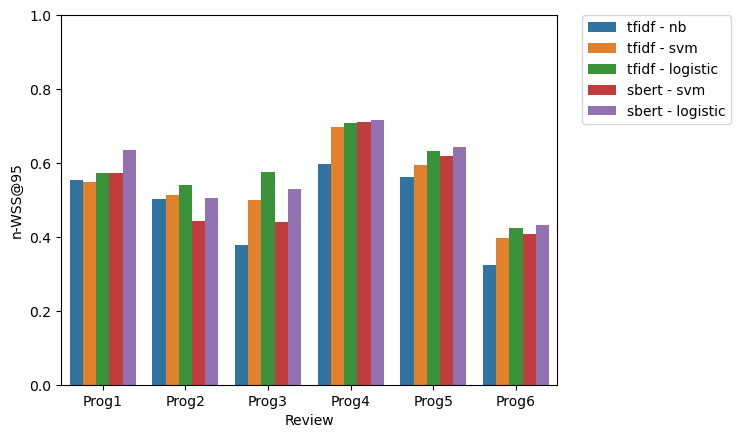

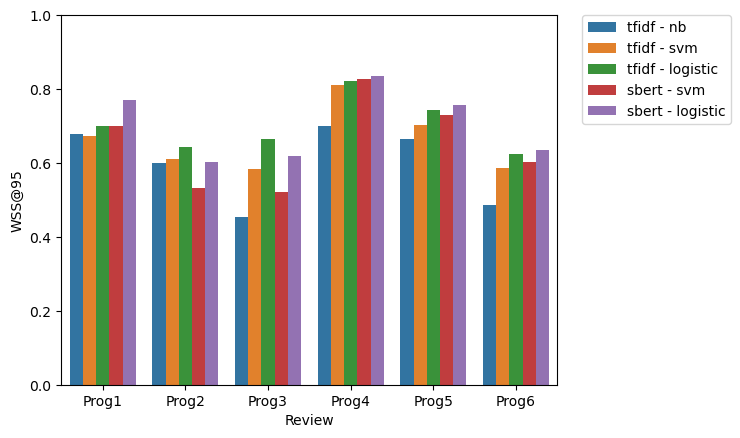

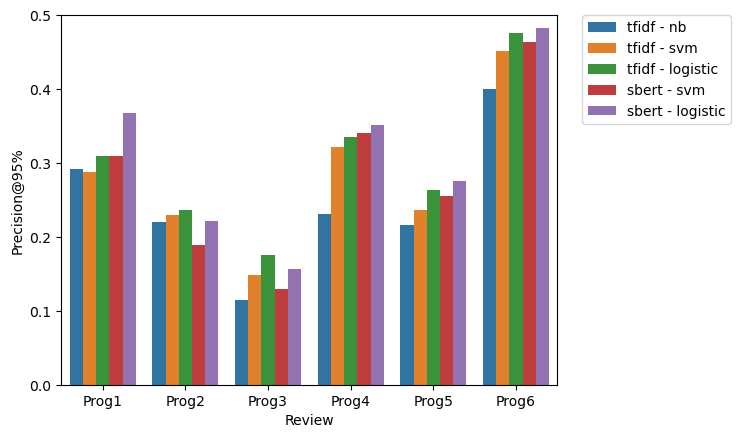

In [25]:
review_types = ['Prog']
generate_histograms(dataset=df_wss_prec_all_values, 
                    x='Review',
                    variables=variables_to_plot, 
                    y_labels=variable_names, 
                    review_types=review_types)

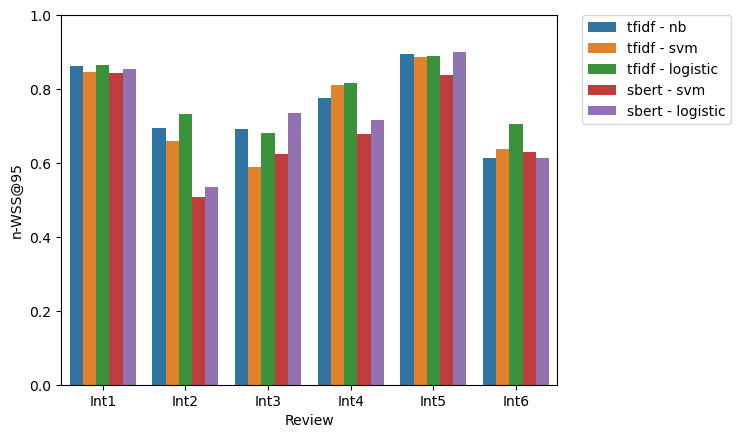

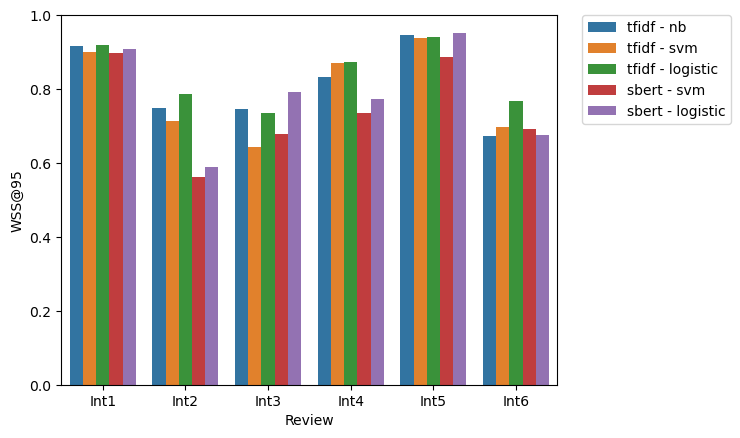

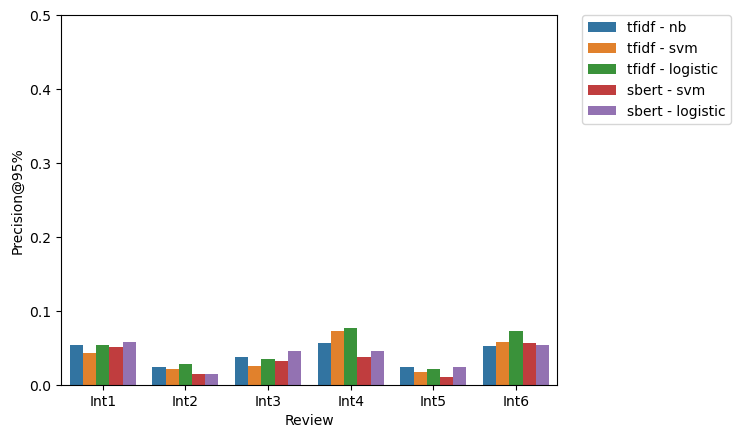

In [26]:
review_types = ['Int']
generate_histograms(dataset=df_wss_prec_all_values[~df_wss_prec_all_values['Review'].str.contains('Int7', na=False)], 
                    x='Review',
                    variables=variables_to_plot, 
                    y_labels=variable_names, 
                    review_types=review_types)

### 8. Create boxplots/lineplots of increasing recall during screening (for results)

Create boxplots for the simulations of the default models (or any other subset of data/modeling methods):

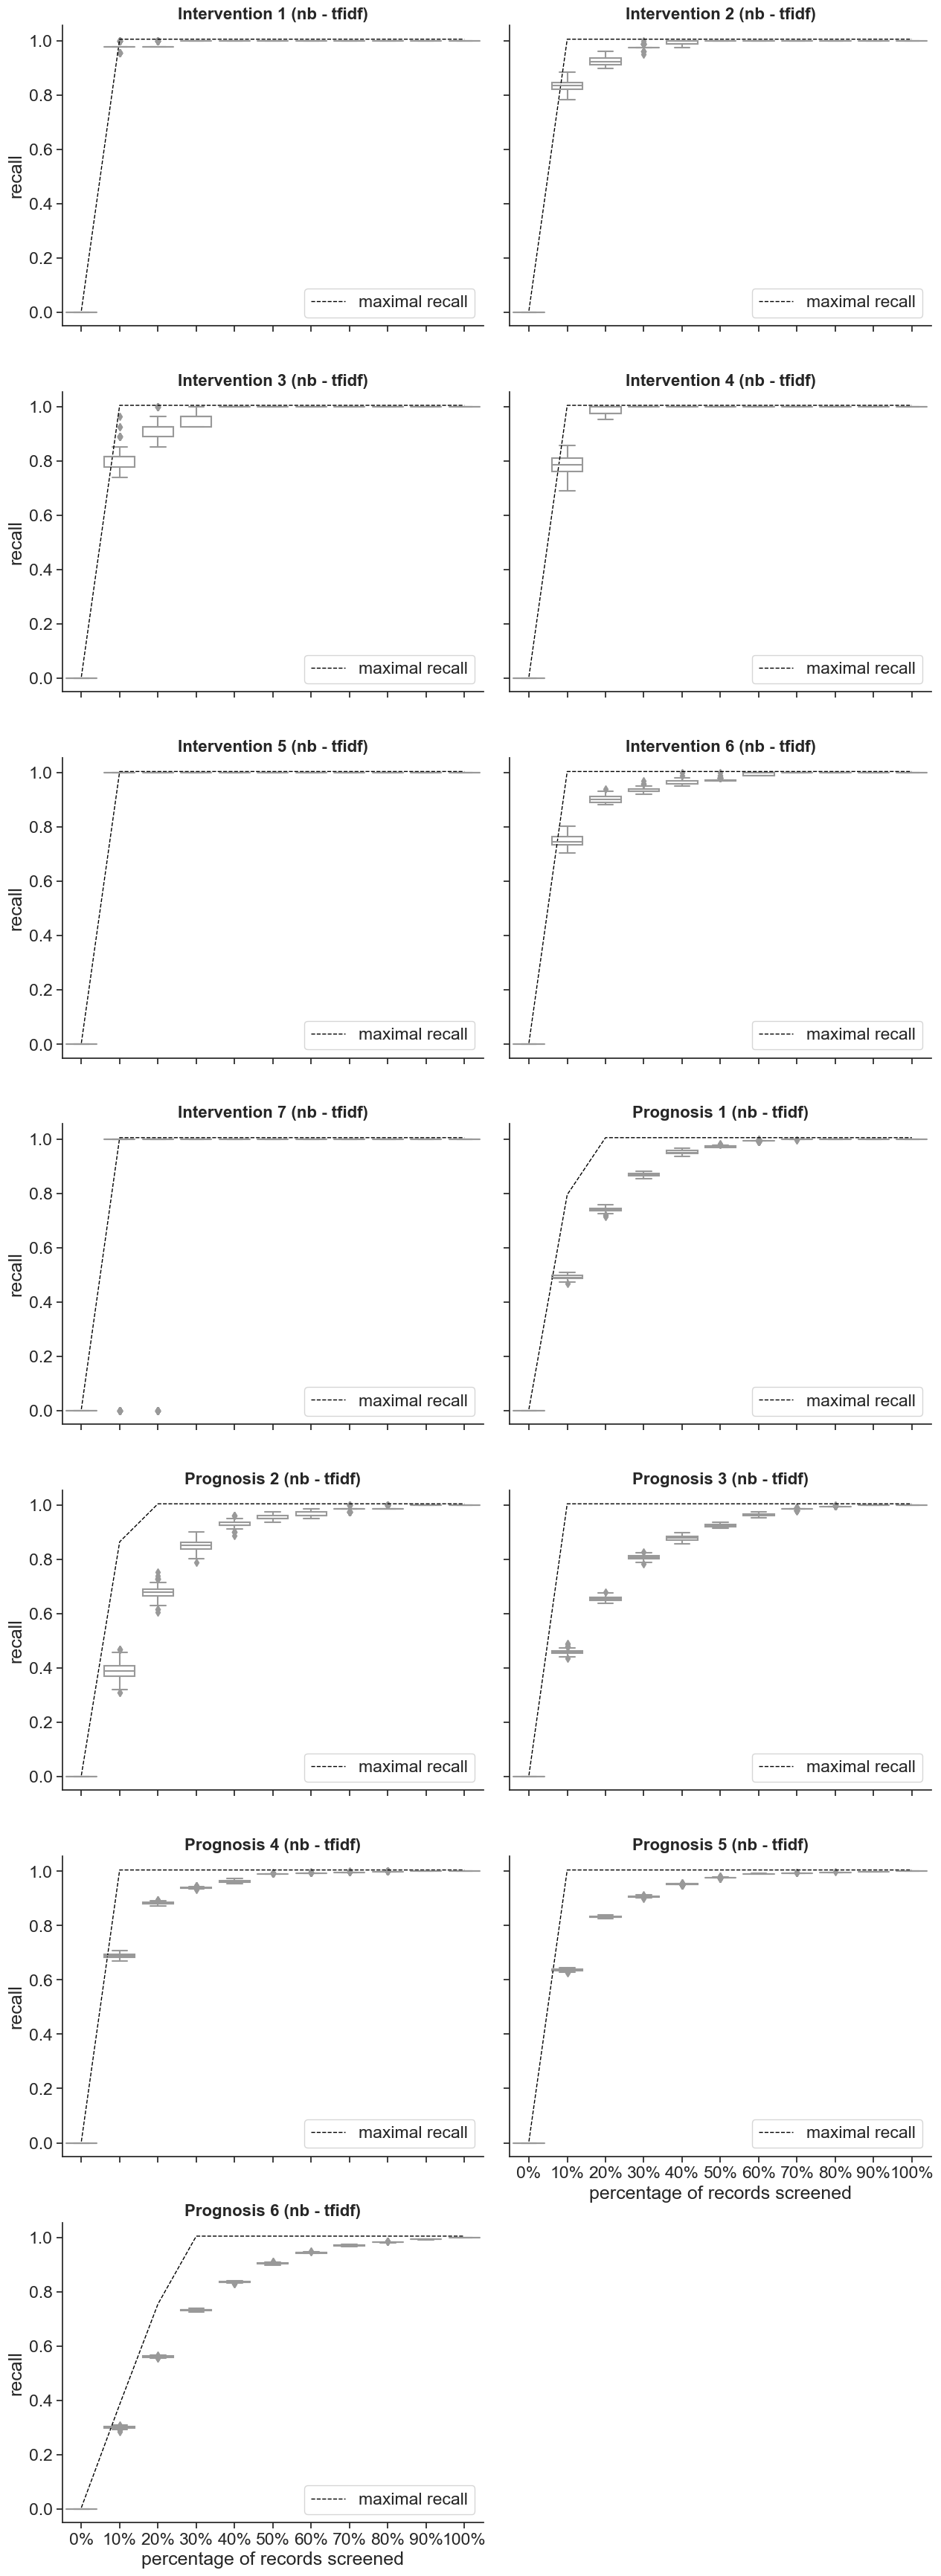

In [27]:
# Optionally choose subset(s) to plot
subset_models = ['nb - tfidf']
subset_reviews = ['Prog', 'Int']

def generate_boxplots(df_prop, df_max_recalls, subset_models = None, subset_reviews = None):
    
    # Select the subset from the dataframe containing all recall values for each proportion screened
    df_boxplots = df_prop.copy()
    
    if subset_models != None:
        models = '|'.join(subset_models)
        df_boxplots = df_boxplots[df_boxplots['Simulation'].str.contains(models, regex=True)]
    if subset_reviews != None:
        reviews = '|'.join(subset_reviews)
        df_boxplots = df_boxplots[df_boxplots['Review'].str.contains(reviews, regex=True)]

    # Create a figure with boxplots for each review-model combination seperately
    sns.set(style = 'ticks', font_scale = 1.5)
    p1 = sns.catplot(data = df_boxplots, x = 'percentage of records screened', y = 'recall',
                     col = 'Simulation', kind = 'box', col_wrap = 2, color = 'white', aspect = 1.3)

    axes = p1.fig.axes
    x_axis = df_boxplots['percentage of records screened'][0:11]

    for i in range(0, len(df_boxplots['Simulation'].unique())):
        review = df_boxplots.loc[df_boxplots['Simulation'] == df_boxplots['Simulation'].unique()[i], 'Review'].values[0]
        max_recalls_per_prop = df_max_recalls.loc[df_max_recalls['Review'] == review]['Maximum recall']    
        axes[i].plot(x_axis, max_recalls_per_prop+0.005, 'k-', linewidth = 1, color = 'black', linestyle = '--', label = "maximal recall")   
        axes[i].legend(loc="lower right")
    p1.set_titles(col_template = "{col_name}", size = 16, weight = 'bold')

    plt.show()
    
generate_boxplots(df_prop, df_max_recalls, subset_models, subset_reviews)

Create lineplots for all simulations (or any other subset of data/modeling methods):

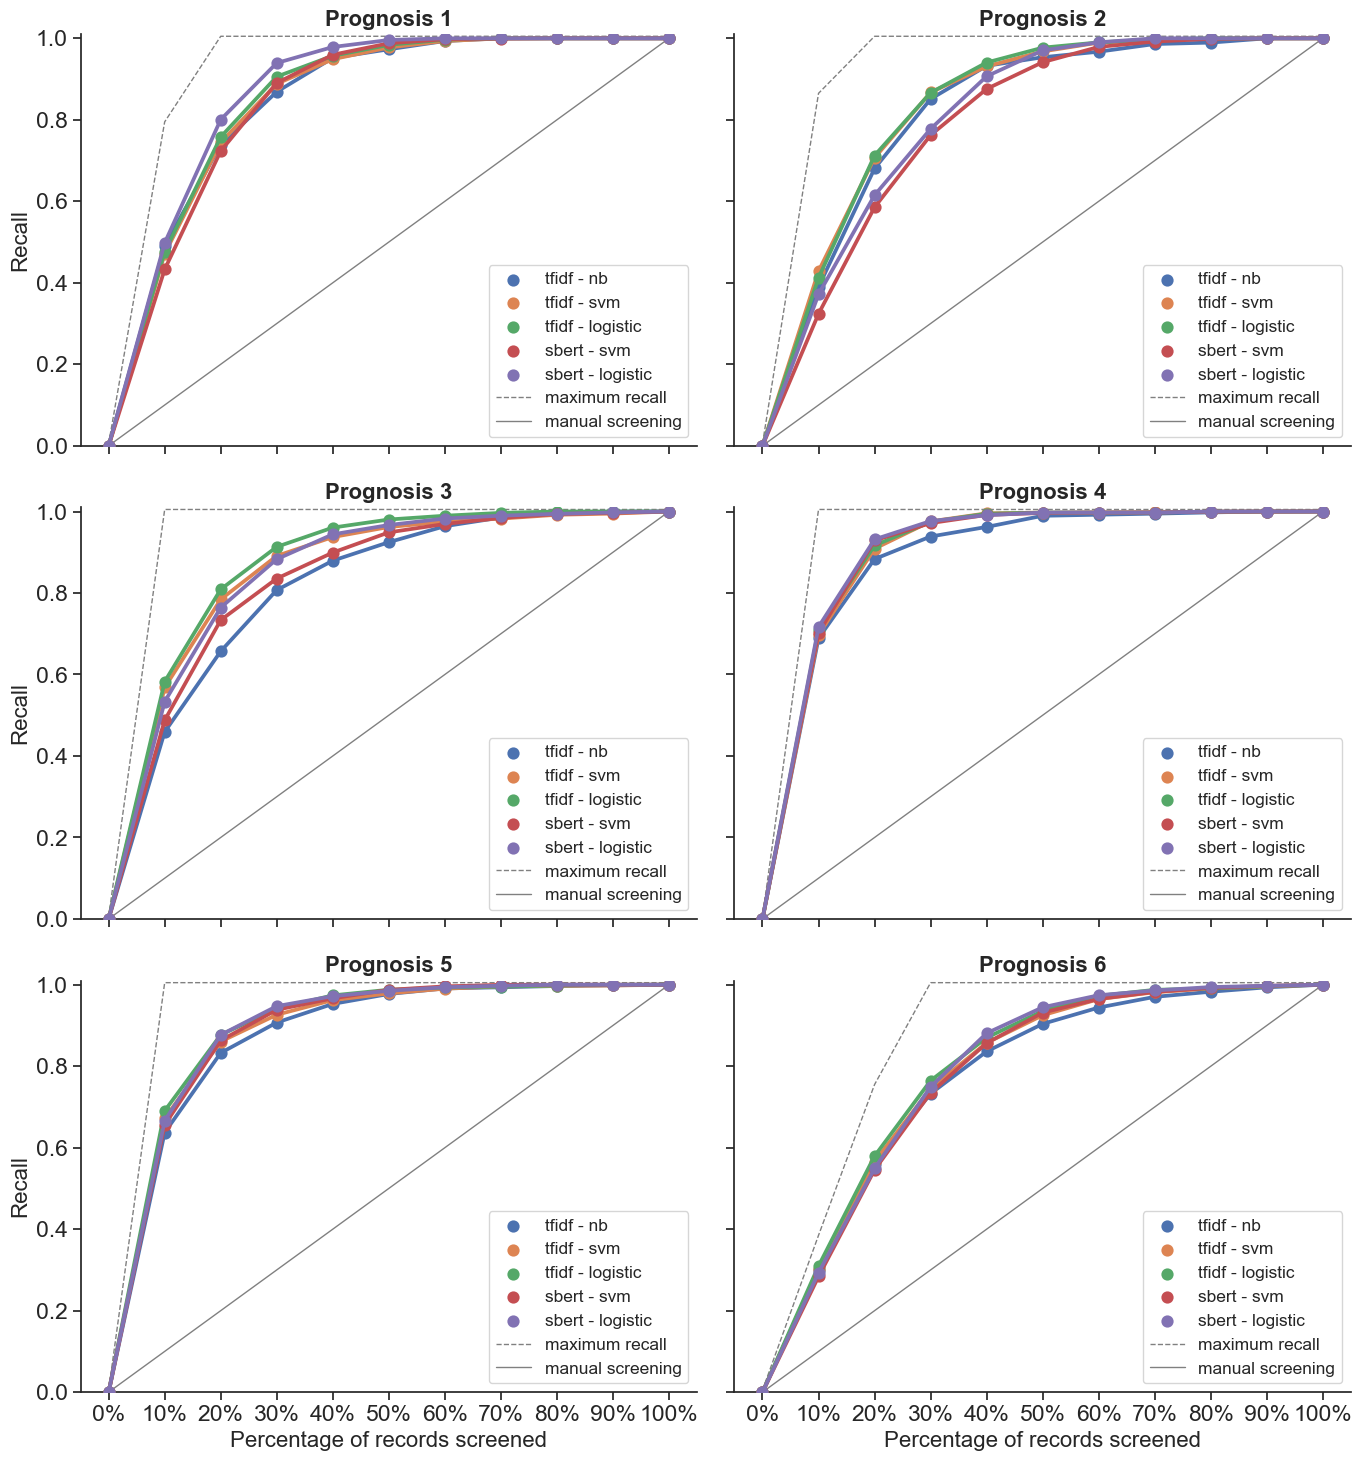

In [28]:
# Optionally choose a subset to plot
subset_reviews = ['Prog']

def generate_lineplots(df_prop, df_max_recalls, subset_reviews = None):
    
    # Select the subset from the dataframe containing all recall values for each proportion screened
    df_lineplots = df_prop.copy()
    
    df_lineplots['Models'] = df_lineplots['Models'].astype(pd.CategoricalDtype(categories=['tfidf - nb',
                                                                  'tfidf - svm',
                                                                  'tfidf - logistic',
                                                                  'sbert - svm',
                                                                  'sbert - logistic']))
    
    if subset_reviews != None:
        reviews = '|'.join(subset_reviews)
        df_lineplots = df_lineplots[df_lineplots['Review'].str.contains(reviews, regex=True)]

    # Create a figure with lineplots for each review-model combination seperately
    p2 = sns.catplot(data = df_lineplots, kind = 'point', 
                     x = 'percentage of records screened', y = 'recall', 
                     col = 'Review_full', 
                     hue = 'Models', 
                     errorbar = 'ci',
                     col_wrap = 2, aspect = 1.4, legend = False
                     )

    axes = p2.fig.axes

    for i in range(0, len(df_lineplots['Review'].unique())):
        max_recalls_per_prop = df_max_recalls.loc[df_max_recalls['Review'] == df_lineplots['Review'].unique()[i]]['Maximum recall']    
        manual_screening = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
        x_axis = df_lineplots['percentage of records screened'][0:len(max_recalls_per_prop)]
        axes[i].plot(x_axis, max_recalls_per_prop + 0.005, 'k-', linewidth = 1, color = 'grey', linestyle = '--', label = "maximum recall") 
        axes[i].plot(x_axis, manual_screening, 'k-', linewidth = 1, color = 'grey', linestyle = '-', label = "manual screening") 
        axes[i].legend(loc="lower right", fontsize = 12.5)
    
    if subset_reviews[0] == 'Int7':
        p2.set_titles('Intervention A1', size = 16, weight = 'bold')
    else:
        p2.set_titles(col_template = "{col_name}", size = 16, weight = 'bold')
    p2.set_xlabels('Percentage of records screened', size = 16)
    p2.set_ylabels('Recall', size = 16)
    p2.set(ylim = (0, 1.01))
    plt.show()

generate_lineplots(df_prop, df_max_recalls, subset_reviews)

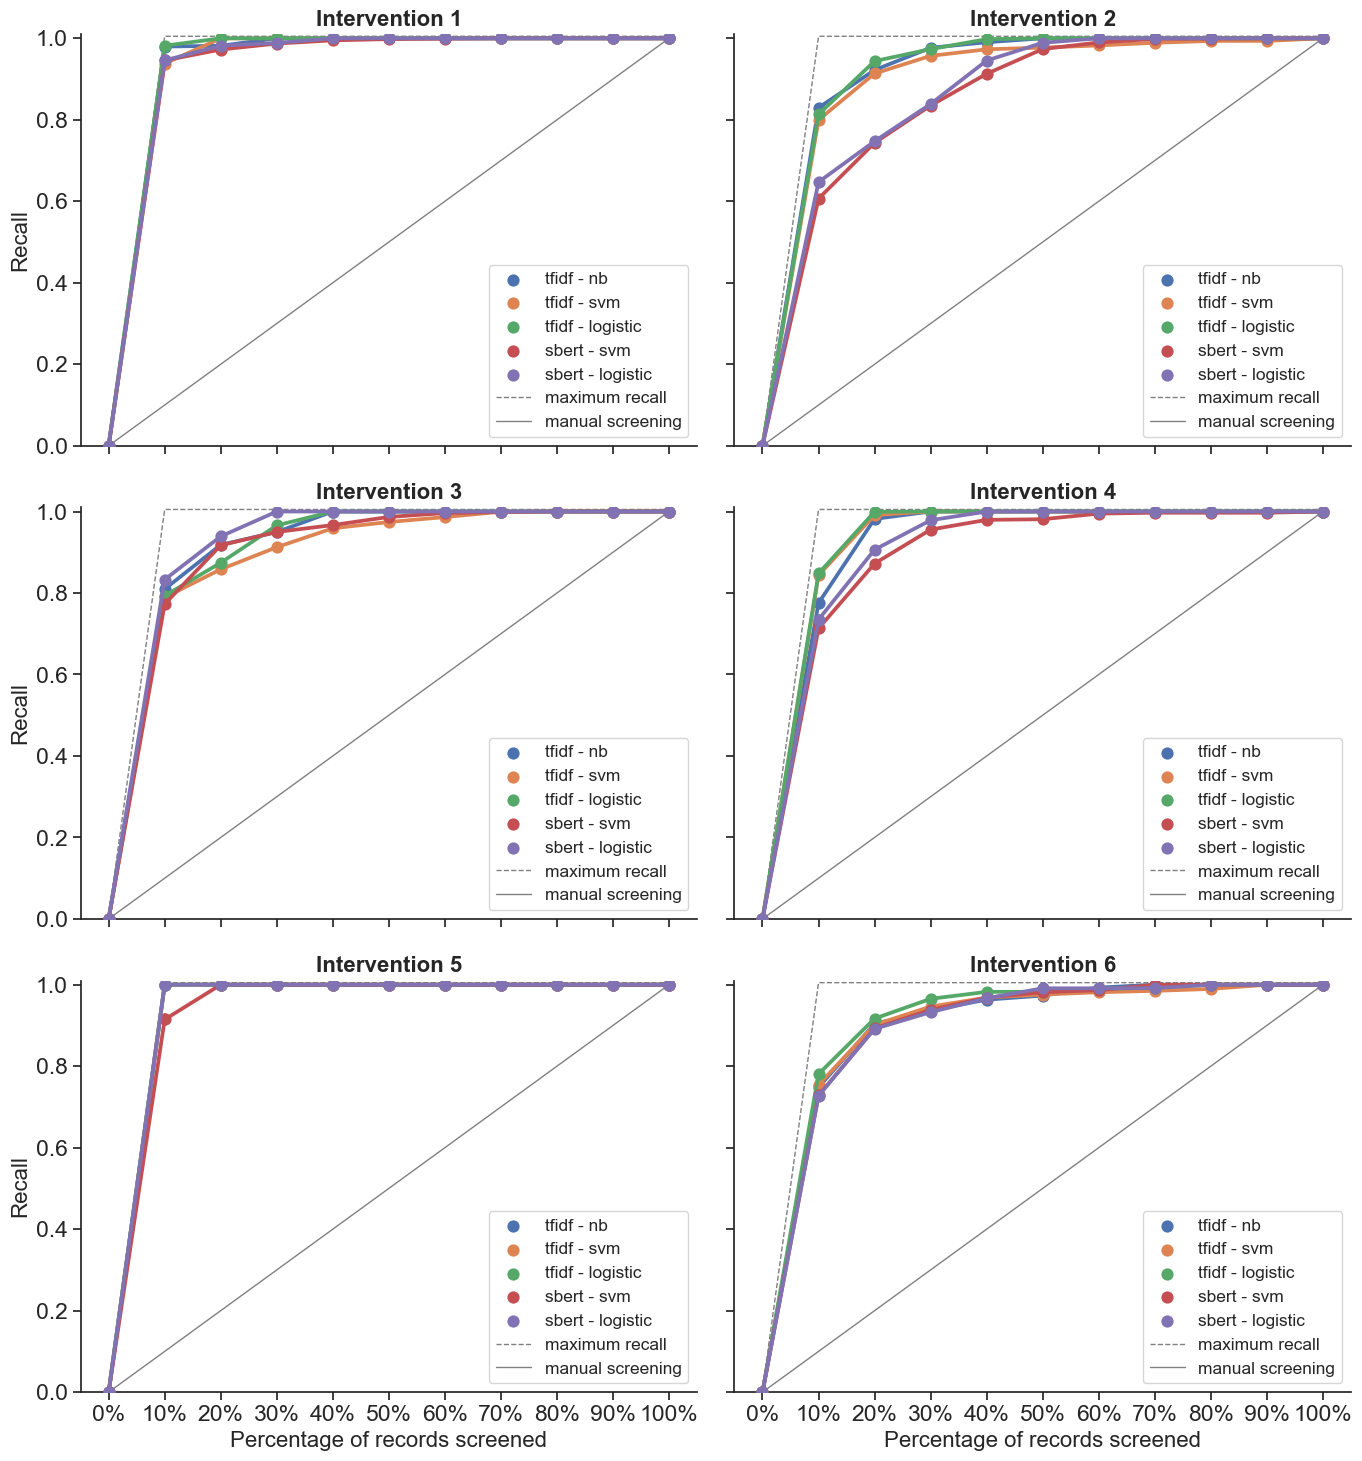

In [29]:
subset_reviews = ['Int1', 'Int2', 'Int3', 'Int4', 'Int5', 'Int6']
generate_lineplots(df_prop, df_max_recalls, subset_reviews)

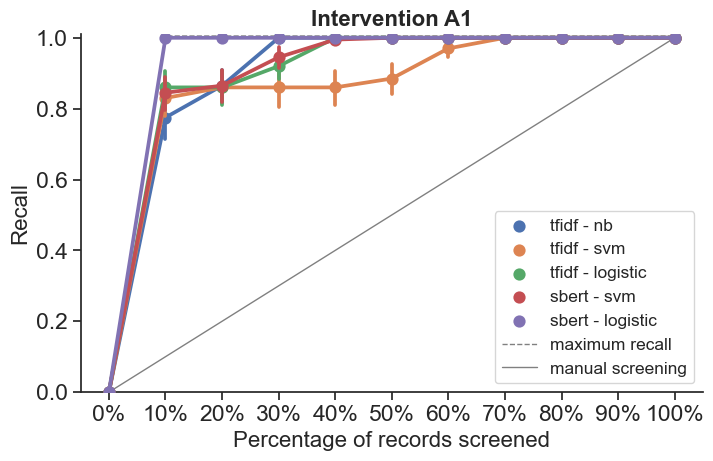

In [30]:
subset_reviews = ['Int7']
generate_lineplots(df_prop, df_max_recalls, subset_reviews)

## Part III: Simulations with adapted review datasets

### 9. Variations in number of (relevant) records 

Create dataframes of manually adapted numbers of (relevant) records that were also used to simulate the semi-automated screening process on the High Performance Computer (HPC)

In [31]:
# Define a function to create a dictionary with subsets of a dataset consisting of varying numbers of records and inclusions:

def df_var_dict(review_name, df, sizes, incl_prop): 
    
    '''
    df (pandas.DataFrame):    a dataframe of a review with at least containing the columns 'abstract', 'title', and 'label_included'
    sizes (list):             a list of integers of dataframe sizes to vary  
    incl_prop (list):         a list of integers of inclusion proportions to vary 
    '''
    
    # First a list of possible size/inclusion combinations is created:
    unique_combinations = []
    for i in range(0, len(sizes)):
        unique_combinations.append([sizes[i],incl_prop[i]])

    # Then a dictionary is created with for each combination a sample of the dataset. If the sample cannot be retrieved,
    # i.e. the dataset size is too small or the inclusion proportion is not available, the respective item in the dictionary remains empty.
    df_dict = {}
    
    # For each combination of size/inclusion proportion:
    for i in range(len(unique_combinations)):
        # Check if the dataframe includes enough records to sample the respective size
        if len(df) >= unique_combinations[i][0]:
            
            
            # Check if the inclusion proportion is possible for the respective size
            if df.loc[df['label_included'] == 1].shape[0] >= int(unique_combinations[i][0] * unique_combinations[i][1]) and df.loc[df['label_included'] == 0].shape[0] >= int(unique_combinations[i][0] - (unique_combinations[i][0] * unique_combinations[i][1])):
                # If so:
                # Sample random inclusions
                incl = df.loc[df['label_included'] == 1].sample(n = int(unique_combinations[i][0] * unique_combinations[i][1]), replace = False, random_state = 1)
                # Sample random exclusions
                excl = df.loc[df['label_included'] == 0].sample(n = int(unique_combinations[i][0] - (unique_combinations[i][0] * unique_combinations[i][1])), replace = False, random_state = 1)
                # Create a dataframe of the inclusions and exclusions
                df_new = pd.concat([incl, excl]).sort_values('authors').reset_index()
                name = review_name + "_" + str(len(df_new)) + "_" + str(unique_combinations[i][1])
            # If the size/inclusion proportion is not possible, leave the dataframe empty
            else:
                name = review_name + "_" + str(len(df_new)) + "_" + str(unique_combinations[i][1])
                df_new = [] 
        else:
            df_new = []
        
        if len(df_new) > 0:
            if df_new['label_included'].sum() <= 10:
                df_new = []
        
        # Store the dataframe in the dictionary of all retrieved dataframes
        if len(df_new) > 0:
            df_dict[name] = df_new
  
    return(df_dict)

# Apply the function:
sizes = [500, 1000, 2000]
incl_prop = [0.1, 0.05, 0.025]
ss_dict = df_var_dict(review_name = 'Int1', df = dfs_int['Int1'], sizes = sizes, incl_prop = incl_prop)                 
ss_dict.update(df_var_dict(review_name = 'Int2', df = dfs_int['Int2'], sizes = sizes, incl_prop = incl_prop))
ss_dict.update(df_var_dict(review_name = 'Int4', df = dfs_int['Int4'], sizes = sizes, incl_prop = incl_prop))
ss_dict.update(df_var_dict(review_name = 'Int6', df = dfs_int['Int6'], sizes = sizes, incl_prop = incl_prop))
ss_dict.update(df_var_dict(review_name = 'Prog3', df = dfs_prog['Prog3'], sizes = sizes, incl_prop = incl_prop))
ss_dict.update(df_var_dict(review_name = 'Prog4', df = dfs_prog['Prog4'], sizes = sizes, incl_prop = incl_prop))
ss_dict.update(df_var_dict(review_name = 'Prog5', df = dfs_prog['Prog5'], sizes = sizes, incl_prop = incl_prop))
ss_dict.update(df_var_dict(review_name = 'Prog6', df = dfs_prog['Prog6'], sizes = sizes, incl_prop = incl_prop))

# Save the keys
ss_sims = list(ss_dict.keys())

### 10. Retrieve and merge the output from all simulations

To assess the performance of the semi-automated screening tool, the classification models, feature extraction models, and/or query models were kept constant while the reviews were manually adapted to consist of equal number of (relevant) records.

In [32]:
path_results_HPC = 'output/simulations_adapted_datasets/'

In [33]:
# Specify the the classification, feature extraction, and query model(s) that were tested
train_models = [NaiveBayesClassifier()]
feature_models = [Tfidf()] 
query_models = [MaxQuery()]

# Specify the number of simulations per review-model combination  
n_simulations = 200 

# Specify the number of sampling seeds of manually adapted datasets
seeds = 5

All the output from the simulations of these variations (conducted on the HPC) can then be retrieved and merged as follows:

In [34]:
# Create a list of the review-model combination names
sim_list_names_ss = []
for review in ss_sims:
    for train_model in train_models:
        for feature_model in feature_models:
            for query_model in query_models:
                review_id = str(review + "_" + train_model.name + "_" + feature_model.name + "_" + query_model.name)
                sim_list_names_ss.append(review_id)

# Derive the results from the HPC retrieved pickle files with each having the rankings of a single simulation
multiple_sims_sizes = []
n_simulations = 200 # number of simulations per review-model combination
for i in range(0, len(sim_list_names_ss)):
    for k in range(1, seeds+1):
        raw_output_ss = {}
        for j in range(1,n_simulations+1):
            if Path(path_results_HPC +'sim_{review_id}_{sim}_{seed}.p'.format(review_id=sim_list_names_ss[i], sim=j, seed = k)).is_file():
                with open(path_results_HPC + 'sim_{review_id}_{sim}_{seed}.p'.format(review_id=sim_list_names_ss[i], sim=j, seed = k),'rb') as f:
                    raw_output_ss.update(pickle.load(f))
        if len(raw_output_ss) > 0:
            review_id = str(sim_list_names_ss[i] + '_' + str(k))
            multiple_sims_sizes.append((review_id, len(ss_dict['_'.join(sim_list_names_ss[0].split('_')[0:3])]), n_simulations, raw_output_ss))

In [35]:
# Save (back-up) the file with the simulation results
# with open(path_results + 'multiple_sims_sizes.p','wb') as f:
#     pickle.dump(multiple_sims_sizes, f)

or the output can be directly opened from the already saved file:

In [36]:
# Open the file with the simulation results
with open(path_results + 'multiple_sims_sizes.p','rb') as f:
    multiple_sims_sizes = pickle.load(f)

### 11. Compute performance metrics from the retrieved simulation output

The proportions (i.e. proportion of records screened) and sample sizes (i.e. the number of records screened) of interest can be defined. These are then used for evaluation of the ranking of the records and to calculate the performance metrics at each of these proportions/sample sizes screened.

In [37]:
proportions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
sample_sizes = list(map(int,list(np.linspace(0, 99, 100,retstep = True)[0]))) + list(map(int,list(np.linspace(100, 12400, 124,retstep = True)[0])))

Using these proportions and sizes, the following function can be used to derive the performance metrics of the simulation(s):

In [38]:
# Use the compute_metrics function to compute the metrics from the retrieved simulation output
#raw_output_sizes = compute_metrics.compute_metrics(multiple_sims_sizes, proportions, sample_sizes)

In [39]:
# Save (back-up) a file with the computed output
# with open(path_results + 'sims_output_sizes.p','wb') as f:
#     pickle.dump(raw_output_sizes, f)

Or directly open the file containing the output (as these especially take a while to run):

In [40]:
# Open the files with the computed output
with open(path_results + 'sims_output_sizes.p','rb') as f:
    raw_output_sizes = pickle.load(f)

### 12. Create raw tables with all performance metrics seperately

Filter the (for now) relevant parts of the output for the results:

In [41]:
evaluation_sizes = {}
for i in range(0, len(raw_output_sizes)):
    evaluation_sizes[raw_output_sizes[i][0]] = []
    evaluation_sizes[raw_output_sizes[i][0]].append(raw_output_sizes[i][3:9])

Create a raw table with the performance metrics for proportions:

In [42]:
# Use the generate_recall_table_prop function to generate a table with all recall values for all proportions
df_prop_sizes = generate_recall_table_prop.generate_recall_table_prop(evaluation_sizes, proportions, n_simulations, data_type = 'adapted')

# Adapt the review names
df_prop_sizes['Review'] = df_prop_sizes.apply(lambda row: row['Review'] + '_' + str(row['Total records']) + '_' + str(row['Relevant records']), axis=1)

df_prop_sizes

,Review,Seed,Total records,Relevant records,Simulation number,Train model,Feature model,Query model,Simulation,percentage of records screened,recall,Review_full,Models
0,Int1_500_0.1,1,500,0.1,1,nb,tfidf,max,Intervention 1 (500 - 0.1),0%,0.000,Intervention 1,tfidf - nb
1,Int1_500_0.1,1,500,0.1,1,nb,tfidf,max,Intervention 1 (500 - 0.1),10%,0.900,Intervention 1,tfidf - nb
2,Int1_500_0.1,1,500,0.1,1,nb,tfidf,max,Intervention 1 (500 - 0.1),20%,0.975,Intervention 1,tfidf - nb
3,Int1_500_0.1,1,500,0.1,1,nb,tfidf,max,Intervention 1 (500 - 0.1),30%,1.000,Intervention 1,tfidf - nb
4,Int1_500_0.1,1,500,0.1,1,nb,tfidf,max,Intervention 1 (500 - 0.1),40%,1.000,Intervention 1,tfidf - nb
...,...,...,...,...,...,...,...,...,...,...,...,...,...
263995,Prog6_2000_0.025,5,2000,0.025,200,nb,tfidf,max,Prognosis 6 (2000 - 0.025),60%,1.000,Prognosis 6,tfidf - nb
263996,Prog6_2000_0.025,5,2000,0.025,200,nb,tfidf,max,Prognosis 6 (2000 - 0.025),70%,1.000,Prognosis 6,tfidf - nb
263997,Prog6_2000_0.025,5,2000,0.025,200,nb,tfidf,max,Prognosis 6 (2000 - 0.025),80%,1.000,Prognosis 6,tfidf - nb
263998,Prog6_2000_0.025,5,2000,0.025,200,nb,tfidf,max,Prognosis 6 (2000 - 0.025),90%,1.000,Prognosis 6,tfidf - nb


Calculate the maximum recall values that could be obtained at each of the proportions screened

In [43]:
# Sort the dictionary
ss_dict_ord = collections.OrderedDict(sorted(ss_dict.items()))
# Use the max_recall_prop function to calculate the maximum achievable recall for each review
df_max_recalls_sizes = max_recall_prop.max_recall_prop(ss_dict_ord, proportions)
df_max_recalls_sizes

,Review,Maximum recall
0,Int1_1000_0.05,0.0
1,Int1_1000_0.05,1.0
2,Int1_1000_0.05,1.0
3,Int1_1000_0.05,1.0
4,Int1_1000_0.05,1.0
...,...,...
259,Prog6_500_0.1,1.0
260,Prog6_500_0.1,1.0
261,Prog6_500_0.1,1.0
262,Prog6_500_0.1,1.0


Create a raw table with the work-saved-over sampling, normalized work-saved-over sampling, workload reduction in number of records, and workload reduction in hours:

In [44]:
# Use the generate_wss_table function to create a table with the workload metrics
df_wss_sizes = generate_wss_table.generate_wss_table(evaluation_sizes, n_simulations, data_type = 'adapted')

# Adapt the review names
df_wss_sizes['Review'] = df_wss_sizes.apply(lambda row: row['Review'] + '_' + str(row['Total records']) + '_' + str(row['Relevant records']), axis=1)

#df_wss_sizes.to_excel('results/table_wss_sizes.xlsx')

df_wss_sizes

,Review,Seed,Total records,Relevant records,Train model,Feature model,Query model,Simulation,WSS@95%,n-WSS@95%,Workload reduction (n),Workload reduction (hours)
0,Int1_500_0.1,1,500,0.1,nb,tfidf,max,1,0.826,0.945455,438,3.6
1,Int1_500_0.1,1,500,0.1,nb,tfidf,max,2,0.818,0.936364,434,3.6
2,Int1_500_0.1,1,500,0.1,nb,tfidf,max,3,0.802,0.918182,426,3.6
3,Int1_500_0.1,1,500,0.1,nb,tfidf,max,4,0.806,0.922727,428,3.6
4,Int1_500_0.1,1,500,0.1,nb,tfidf,max,5,0.826,0.945455,438,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...
23995,Prog6_2000_0.025,5,2000,0.025,nb,tfidf,max,196,0.504,0.559794,1108,9.2
23996,Prog6_2000_0.025,5,2000,0.025,nb,tfidf,max,197,0.474,0.528866,1048,8.7
23997,Prog6_2000_0.025,5,2000,0.025,nb,tfidf,max,198,0.501,0.556701,1102,9.2
23998,Prog6_2000_0.025,5,2000,0.025,nb,tfidf,max,199,0.504,0.559794,1108,9.2


Create a raw table with the precision metric:

In [45]:
# Output table for precision

df_prec_sizes = pd.DataFrame()
length = n_simulations
for key, value in evaluation_sizes.items():
    names = key.split('_')
    review = [names[0]] * length
    n_records = [names[1]] * length
    rel_records = [names[2]] * length
    train_model = [names[3]] * length
    feature_model = [names[4]] * length
    query_model = [names[5]] * length
    seed = [names[6]] * length
    simulations = range(1, n_simulations+1)
    precision = value[0][4]['Precision'] ###
    df_sim = pd.DataFrame(list(zip(review, seed, n_records, rel_records, train_model, feature_model, query_model, simulations, precision)),
                           columns = ['Review', 'Seed', 'Total records', 'Relevant records', 'Train model', 'Feature model', 'Query model', 'Simulation', 'Precision@95%'])
    df_prec_sizes = pd.concat([df_prec_sizes, df_sim])
    
    df_prec_sizes = df_prec_sizes.reset_index(drop = True)
    
df_prec_sizes['Review'] = df_prec_sizes.apply(lambda row: row['Review'] + '_' + str(row['Total records']) + '_' + str(row['Relevant records']), axis=1)

df_prec_sizes

,Review,Seed,Total records,Relevant records,Train model,Feature model,Query model,Simulation,Precision@95%
0,Int1_500_0.1,1,500,0.1,nb,tfidf,max,1,0.596774
1,Int1_500_0.1,1,500,0.1,nb,tfidf,max,2,0.575758
2,Int1_500_0.1,1,500,0.1,nb,tfidf,max,3,0.513514
3,Int1_500_0.1,1,500,0.1,nb,tfidf,max,4,0.527778
4,Int1_500_0.1,1,500,0.1,nb,tfidf,max,5,0.596774
...,...,...,...,...,...,...,...,...,...
23995,Prog6_2000_0.025,5,2000,0.025,nb,tfidf,max,196,0.041480
23996,Prog6_2000_0.025,5,2000,0.025,nb,tfidf,max,197,0.039916
23997,Prog6_2000_0.025,5,2000,0.025,nb,tfidf,max,198,0.042316
23998,Prog6_2000_0.025,5,2000,0.025,nb,tfidf,max,199,0.041480


### 13. Process raw tables into pooled tables (for results)

Create a table with the results of wss/workload reduction and precision combined:

In [46]:
df_wss_prec_all_values_sizes, df_wss_prec_sizes = generate_results_table.generate_results_table(df_wss_sizes, df_prec_sizes, data_type = 'adapted')
df_wss_prec_all_values_sizes[['Review', 'Total records', 'Relevant records']] = df_wss_prec_all_values_sizes['Review'].str.split('_', expand=True)

#df_wss_prec_sizes.to_excel('results/table_WSS_precision_sizes.xlsx')
df_wss_prec_all_values_sizes

,Review,Seed,Total records,Relevant records,Train model,Feature model,Mean_WSS95,ci95_hi_WSS95,ci95_lo_WSS95,Mean_nWSS95,...,Mean_prec95,ci95_hi_prec95,ci95_lo_prec95,Mean_workred_n,ci95_hi_workred_n,ci95_lo_workred_n,Mean_workred_hr,ci95_hi_workred_hr,ci95_lo_workred_hr,Models
0,Int1,1,1000,0.05,nb,tfidf,0.840,0.842,0.838,0.923,...,0.350,0.357,0.344,890,892,888,7.4,7.4,7.4,tfidf - nb
1,Int1,2,1000,0.05,nb,tfidf,0.827,0.829,0.825,0.910,...,0.313,0.317,0.309,877,879,875,7.3,7.3,7.3,tfidf - nb
2,Int1,3,1000,0.05,nb,tfidf,0.843,0.845,0.841,0.927,...,0.354,0.360,0.349,893,895,891,7.4,7.5,7.4,tfidf - nb
3,Int1,4,1000,0.05,nb,tfidf,0.833,0.835,0.830,0.916,...,0.326,0.332,0.321,883,885,880,7.4,7.4,7.3,tfidf - nb
4,Int1,5,1000,0.05,nb,tfidf,0.809,0.812,0.807,0.891,...,0.269,0.274,0.264,859,862,857,7.2,7.2,7.1,tfidf - nb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Prog6,1,500,0.1,nb,tfidf,0.450,0.469,0.430,0.518,...,0.165,0.171,0.158,250,260,240,2.1,2.2,2.0,tfidf - nb
116,Prog6,2,500,0.1,nb,tfidf,0.443,0.451,0.435,0.510,...,0.146,0.148,0.145,246,250,242,2.1,2.1,2.0,tfidf - nb
117,Prog6,3,500,0.1,nb,tfidf,0.613,0.616,0.609,0.703,...,0.222,0.224,0.220,331,333,330,2.8,2.8,2.7,tfidf - nb
118,Prog6,4,500,0.1,nb,tfidf,0.504,0.509,0.500,0.580,...,0.168,0.169,0.167,277,280,275,2.3,2.3,2.3,tfidf - nb


In [47]:
df_wss_prec_sizes[['Review', 'Total records', 'Relevant records']] = df_wss_prec_sizes['Review'].str.split('_', expand=True)
df_wss_prec_sizes

,Review,Seed,Total records,Relevant records,Train model,Feature model,WSS@95%recall (CI),n-WSS@95%recall (CI),Precision@95%recall (CI),Workload reduction in record numbers (CI),Workload reduction in hours (CI)
0,Int1,1,1000,0.05,nb,tfidf,0.840 (0.838-0.842),0.923 (0.921-0.926),0.350 (0.344-0.357),890 (888-892),7.4 (7.4-7.4)
1,Int1,2,1000,0.05,nb,tfidf,0.827 (0.825-0.829),0.910 (0.908-0.912),0.313 (0.309-0.317),877 (875-879),7.3 (7.3-7.3)
2,Int1,3,1000,0.05,nb,tfidf,0.843 (0.841-0.845),0.927 (0.925-0.929),0.354 (0.349-0.360),893 (891-895),7.4 (7.4-7.5)
3,Int1,4,1000,0.05,nb,tfidf,0.833 (0.830-0.835),0.916 (0.913-0.918),0.326 (0.321-0.332),883 (880-885),7.4 (7.3-7.4)
4,Int1,5,1000,0.05,nb,tfidf,0.809 (0.807-0.812),0.891 (0.888-0.893),0.269 (0.264-0.274),859 (857-862),7.2 (7.1-7.2)
...,...,...,...,...,...,...,...,...,...,...,...
115,Prog6,1,500,0.1,nb,tfidf,0.450 (0.430-0.469),0.518 (0.495-0.540),0.165 (0.158-0.171),250 (240-260),2.1 (2.0-2.2)
116,Prog6,2,500,0.1,nb,tfidf,0.443 (0.435-0.451),0.510 (0.501-0.519),0.146 (0.145-0.148),246 (242-250),2.1 (2.0-2.1)
117,Prog6,3,500,0.1,nb,tfidf,0.613 (0.609-0.616),0.703 (0.699-0.707),0.222 (0.220-0.224),331 (330-333),2.8 (2.7-2.8)
118,Prog6,4,500,0.1,nb,tfidf,0.504 (0.500-0.509),0.580 (0.575-0.585),0.168 (0.167-0.169),277 (275-280),2.3 (2.3-2.3)


### 14. Create histograms for WSS and precision (for results)

Replace the numbering in the output of the reviews since Prognosis review 5 is not included in our study

Create histograms for (n-)WSS and precision for intervention and prognosis reviews seperately

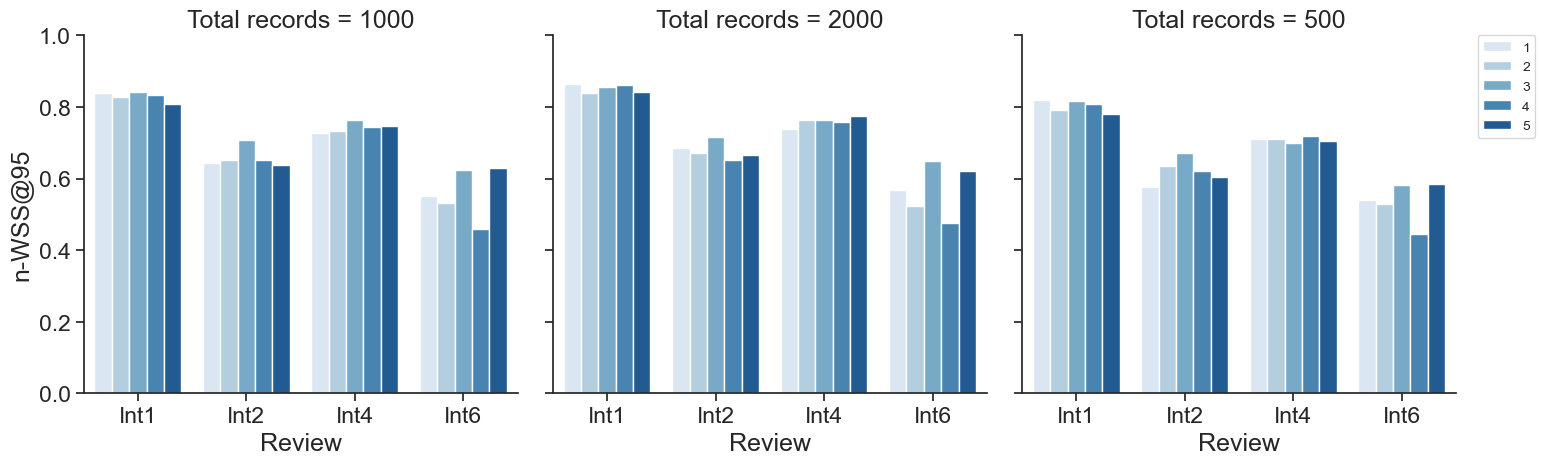

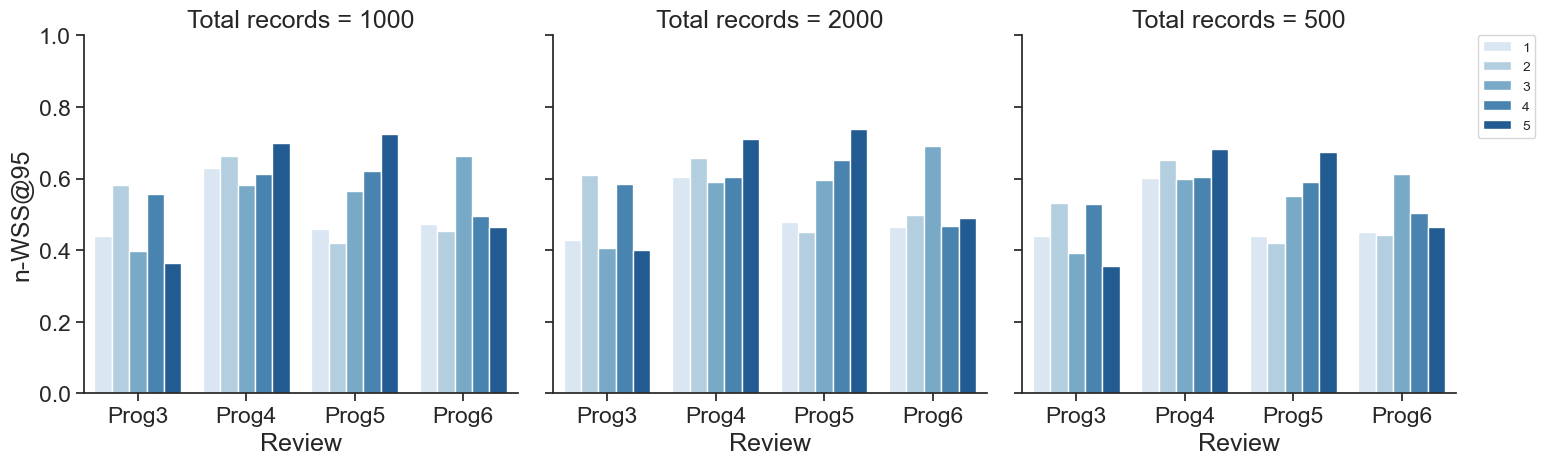

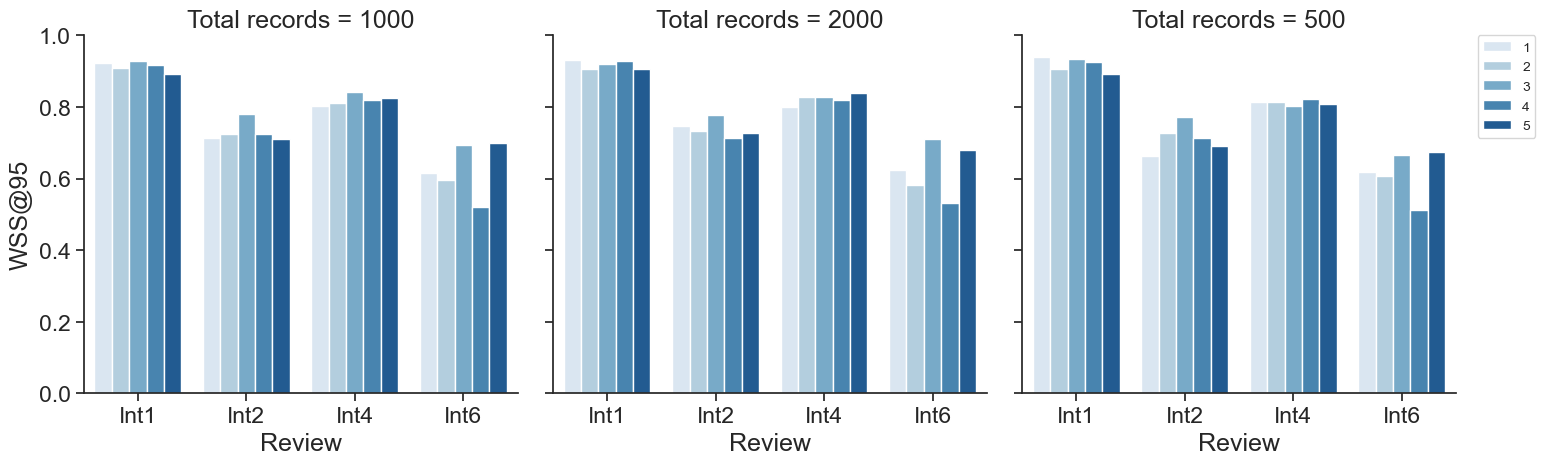

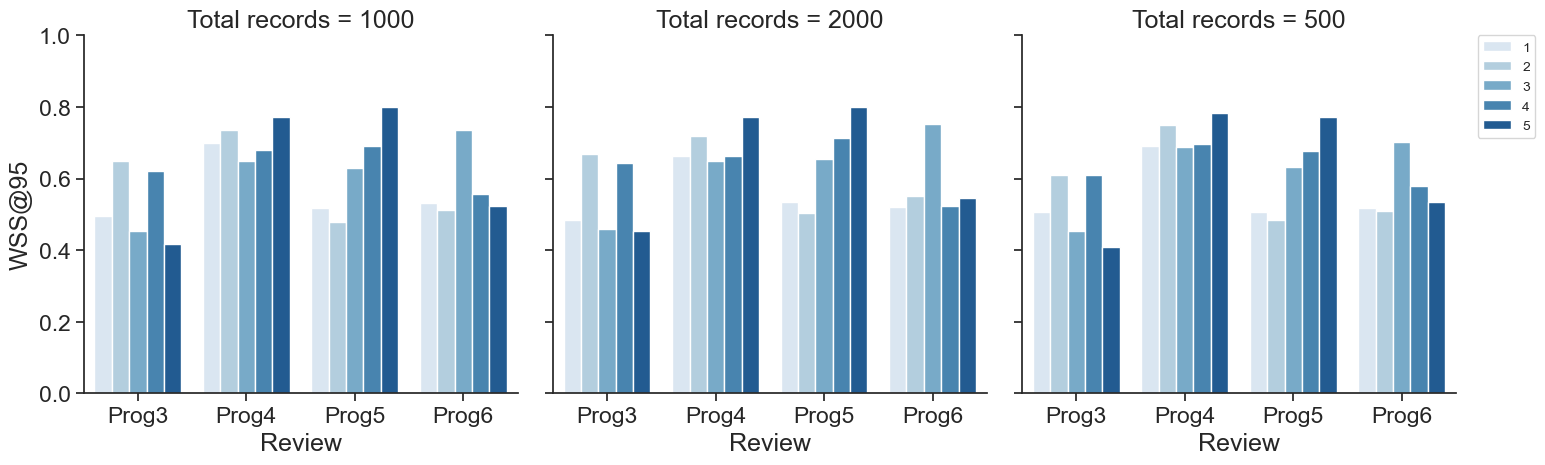

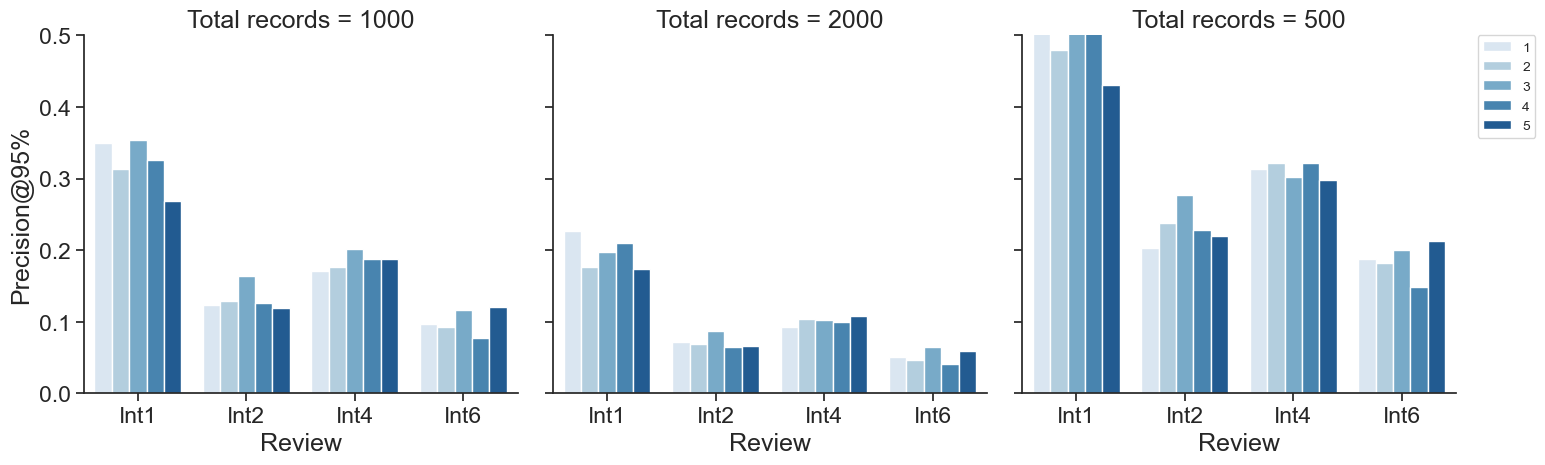

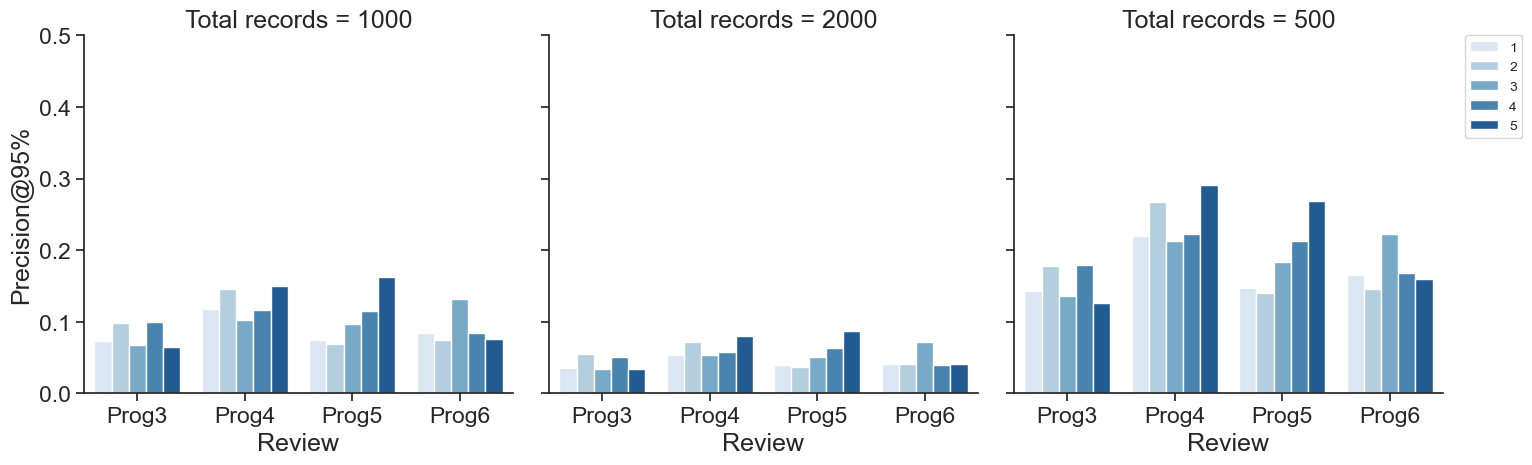

In [48]:
def generate_histograms(dataset, x, variables, y_labels, review_types, hue = 'Models'):
    
    # Change dtype to numeric
    for variable in variables:
        dataset[variable] = pd.to_numeric(dataset[variable])
        
    # Create a histogram for each variable and review type
    for i in range(0, len(variables)):
        for j in review_types:
            
            sns.catplot(x=x, y=variables[i], hue=hue, palette='Blues', col = 'Total records', kind='bar',
                        legend = False,
                        data=dataset[dataset['Review'].str.startswith(j)]).set(ylabel=y_labels[i],ylim=(0,y_lims[i]))
            plt.legend(fontsize='10', title_fontsize='14', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.show()
            
# Choose variables to plot
variables_to_plot = ['Mean_WSS95', 'Mean_nWSS95', 'Mean_prec95']
variable_names = ['n-WSS@95', 'WSS@95', 'Precision@95%']
y_lims = [1,1,0.5]
review_types = ['Int', 'Prog']
            
generate_histograms(dataset=df_wss_prec_all_values_sizes, 
                    x='Review', 
                    variables=variables_to_plot, 
                    y_labels=variable_names, 
                    review_types=review_types, 
                    hue='Seed')

### 15. Create lineplots of increasing recall during screening (for results)

Create lineplots for all simulations (or any other subset of data/modeling methods):

In [49]:
def generate_lineplots(df_prop_ed, df_max_recalls_ed, subset_reviews = None):
    
    # Select the subset from the dataframe containing all recall values for each proportion screened
    df_lineplots = df_prop_ed.copy()
    
    df_lineplots['Models'] = df_lineplots['Models'].astype(pd.CategoricalDtype(categories=['tfidf - nb',
                                                                  'tfidf - svm',
                                                                  'tfidf - logistic',
                                                                  'sbert - svm',
                                                                  'sbert - logistic']))
    
    if subset_reviews != None:
        reviews = '|'.join(subset_reviews)
        df_lineplots = df_lineplots[df_lineplots['Review'].str.contains(reviews, regex=True)]

    # Create a figure with lineplots for each review-model combination seperately
    p2 = sns.catplot(data = df_lineplots, kind = 'point', 
                     x = 'percentage of records screened', y = 'recall', 
                     col = 'Review_full', 
                     hue = 'Seed', 
                     errorbar = 'ci',
                     palette = 'Blues',
                     col_wrap = 2, aspect = 1.4, legend = False
                     )

    axes = p2.fig.axes

    for i in range(0, len(df_lineplots['Review'].unique())):
        max_recalls_per_prop = df_max_recalls_ed.loc[df_max_recalls_ed['Review'] == df_lineplots['Review'].unique()[i]]['Maximum recall']    
        manual_screening = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
        x_axis = df_lineplots['percentage of records screened'][0:len(max_recalls_per_prop)]
        axes[i].plot(x_axis, max_recalls_per_prop + 0.005, 'k-', linewidth = 1, color = 'grey', linestyle = '--', label = "maximum recall") 
        axes[i].plot(x_axis, manual_screening, 'k-', linewidth = 1, color = 'grey', linestyle = '-', label = "manual screening") 
        axes[i].legend(loc="lower right", fontsize = 12.5)
    
    if subset_reviews[0] == 'Int8':
        p2.set_titles('Intervention A1', size = 16, weight = 'bold')
    else:
        p2.set_titles(col_template = "{col_name}", size = 16, weight = 'bold')
    p2.set_xlabels('Percentage of records screened', size = 16)
    p2.set_ylabels('Recall', size = 16)
    p2.set(ylim = (0, 1.01))
    plt.show()

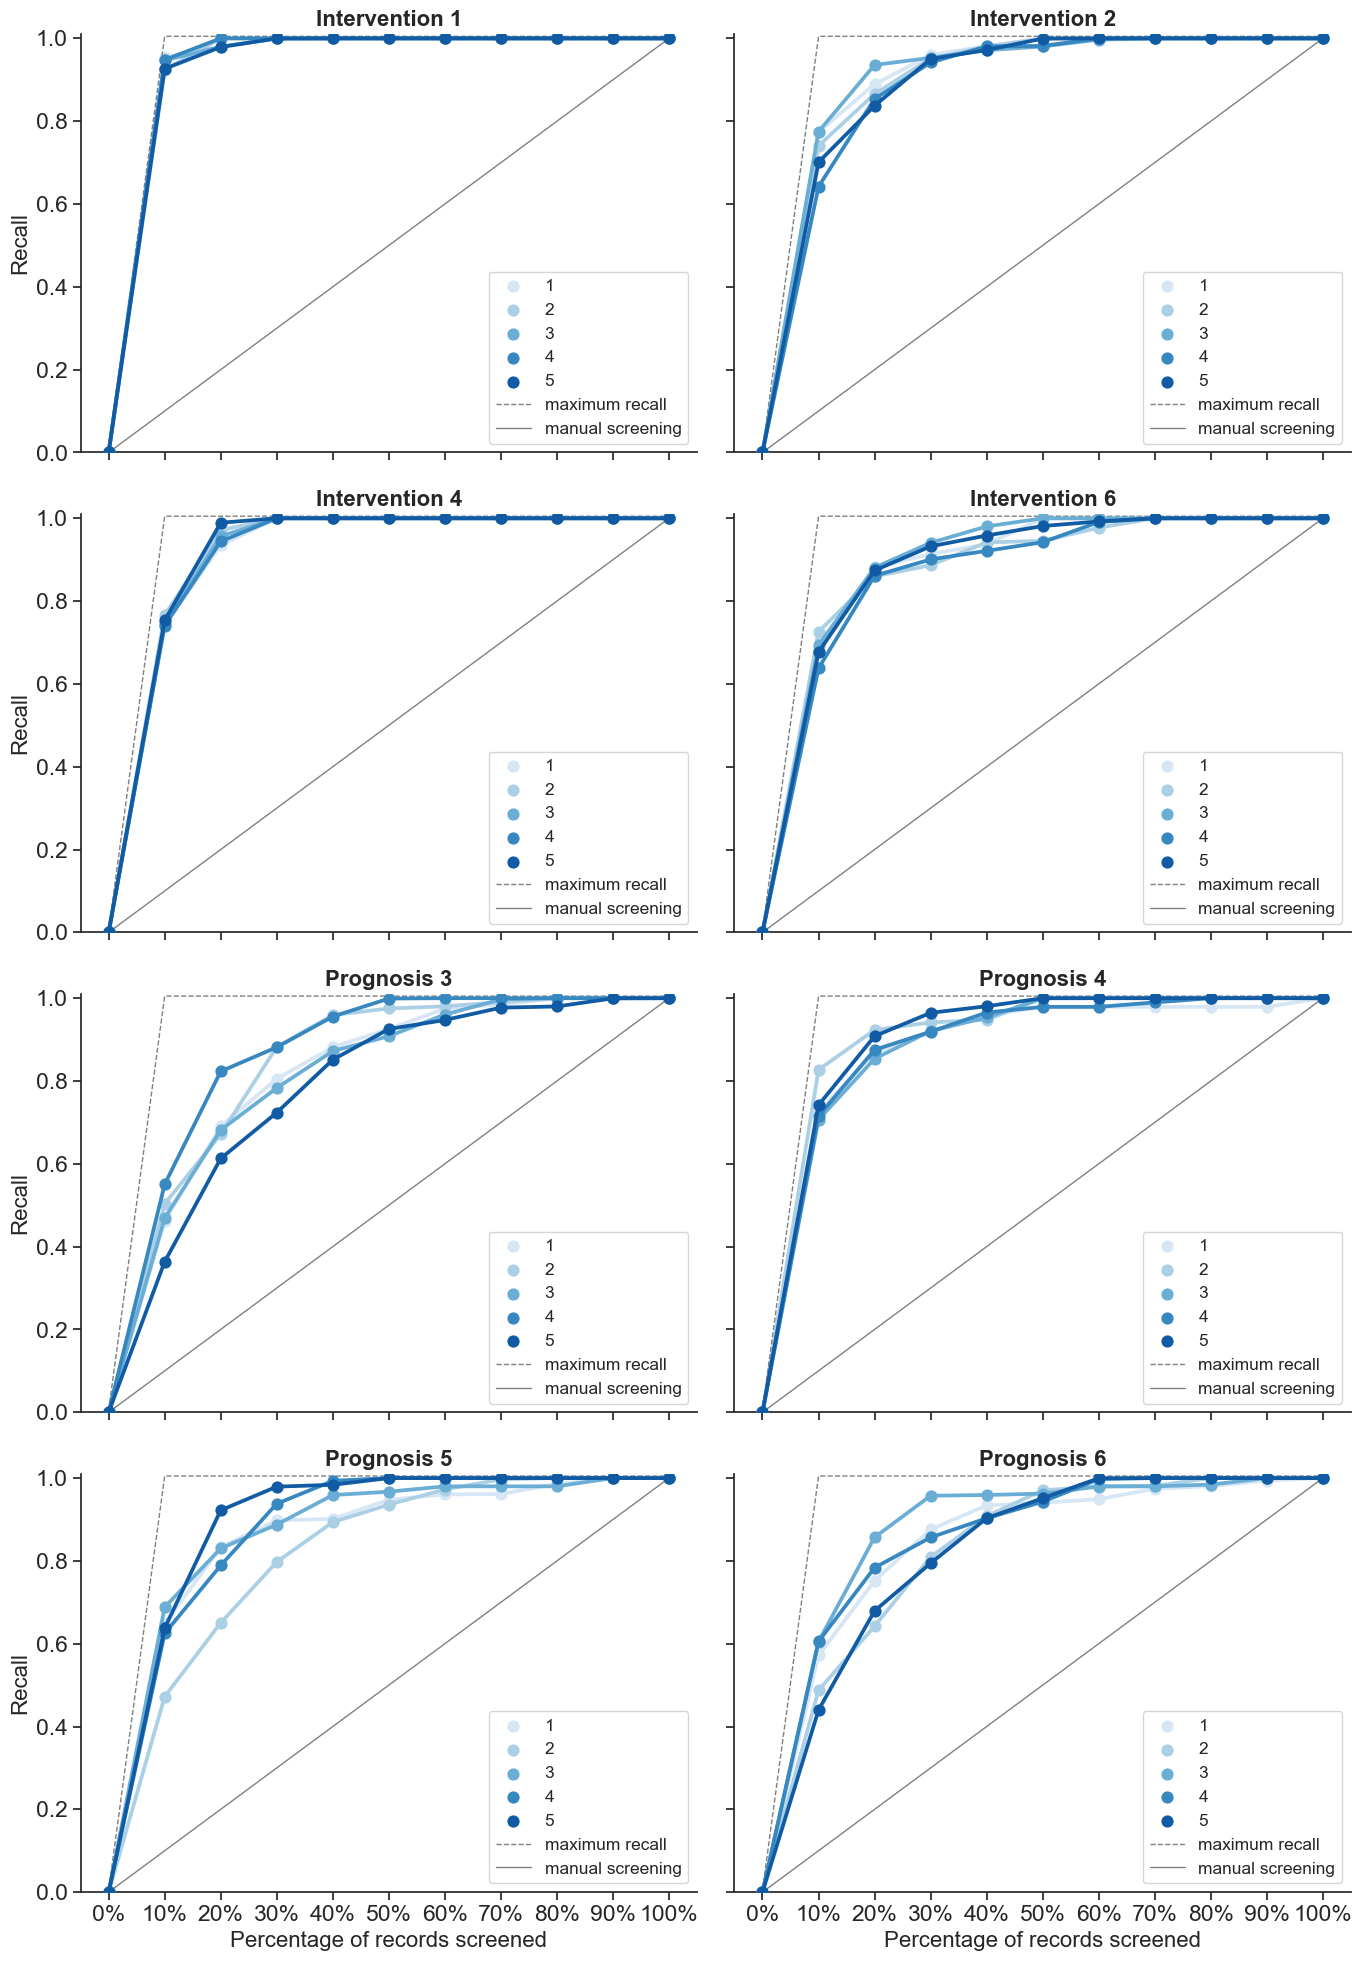

In [50]:
subset_reviews = ['2000']
generate_lineplots(df_prop_sizes, df_max_recalls_sizes, subset_reviews)

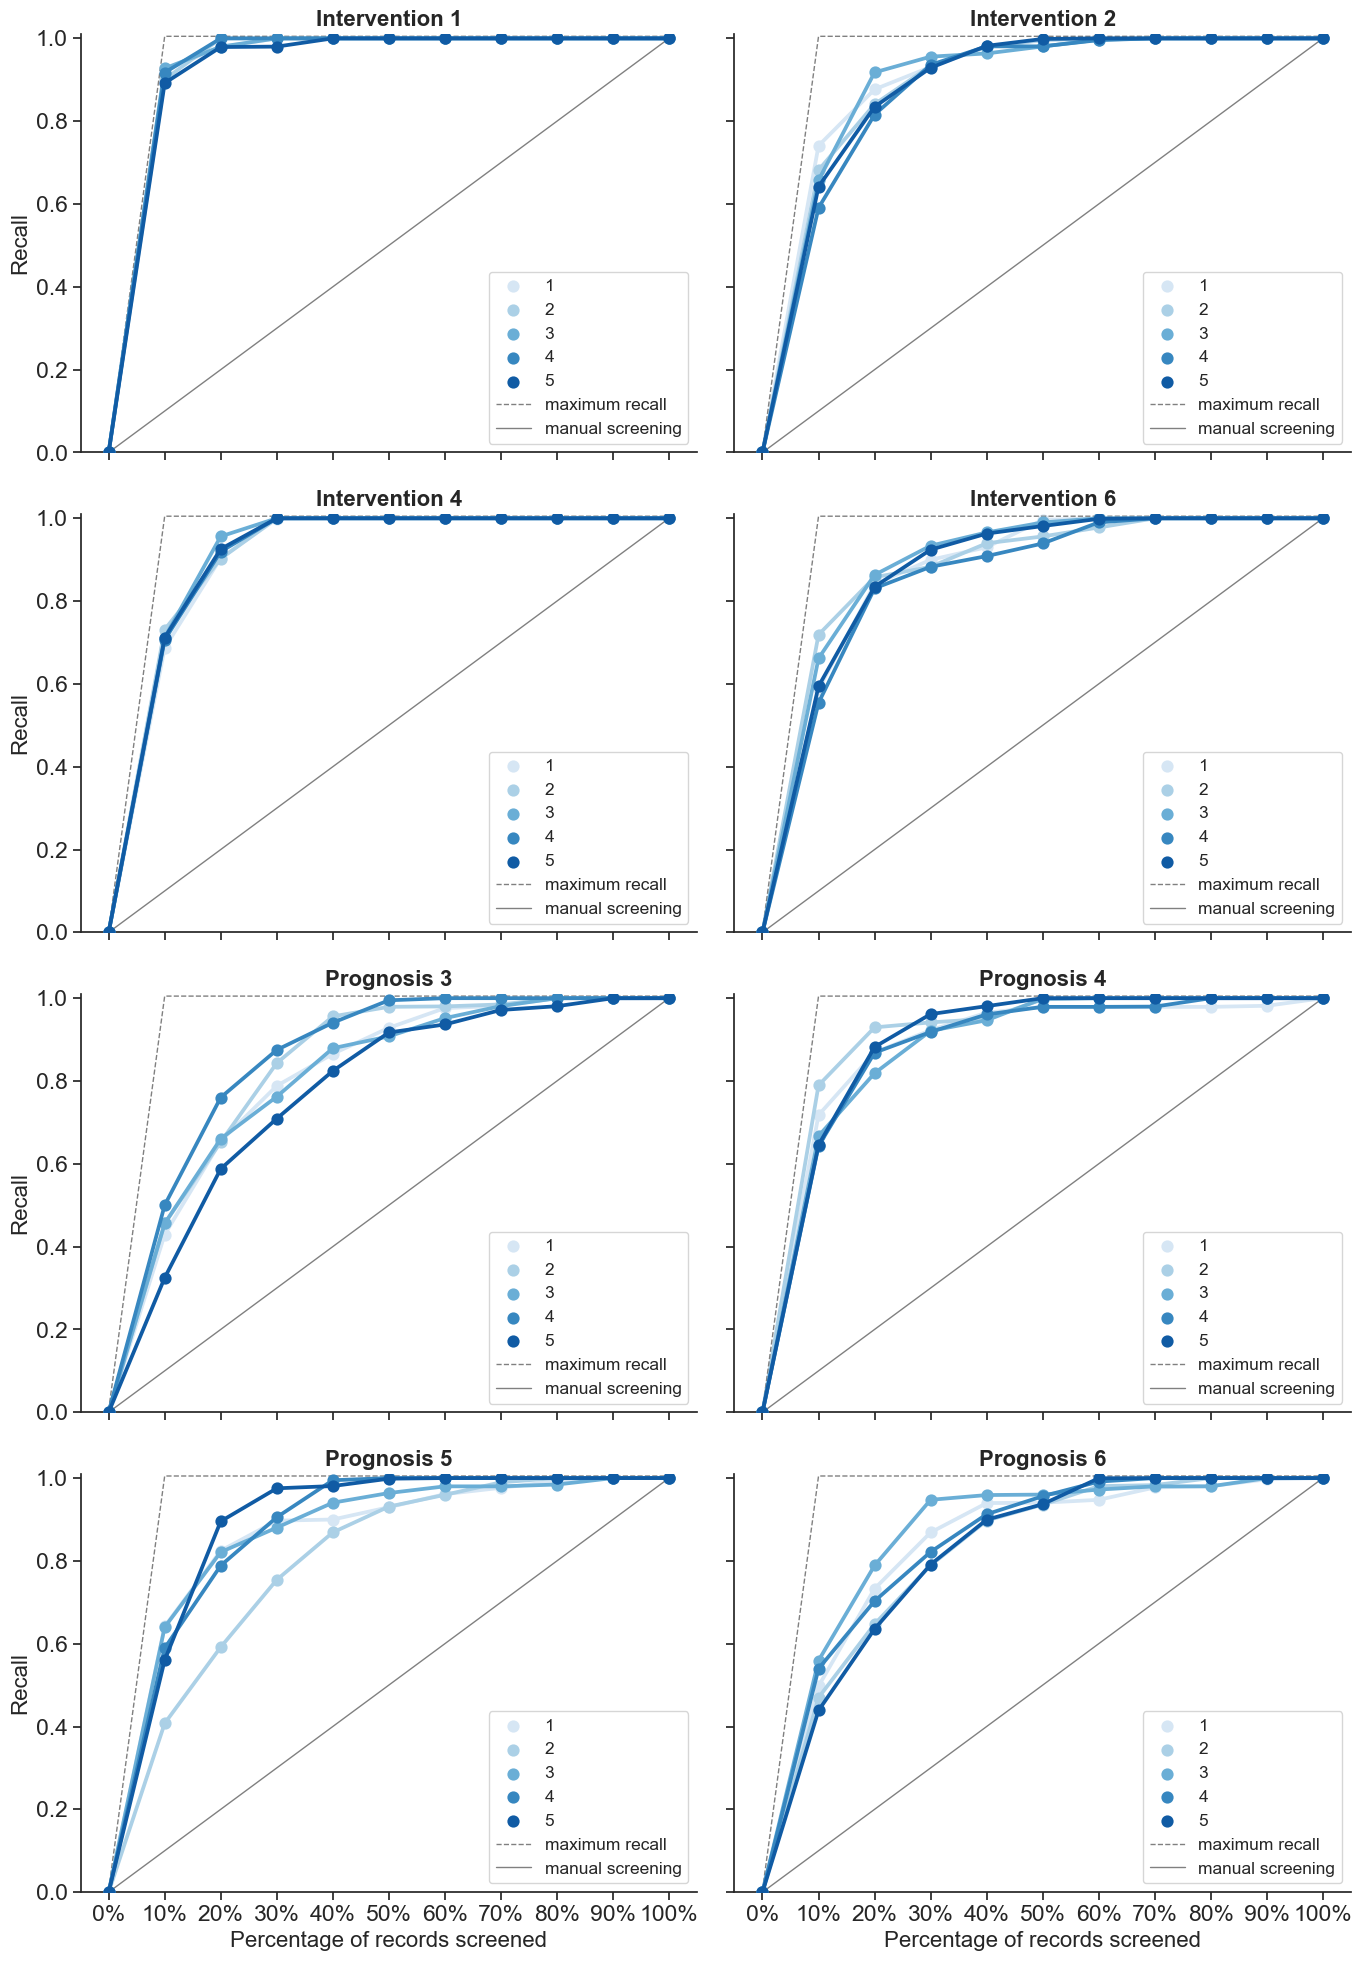

In [51]:
subset_reviews = ['1000']
generate_lineplots(df_prop_sizes, df_max_recalls_sizes, subset_reviews)

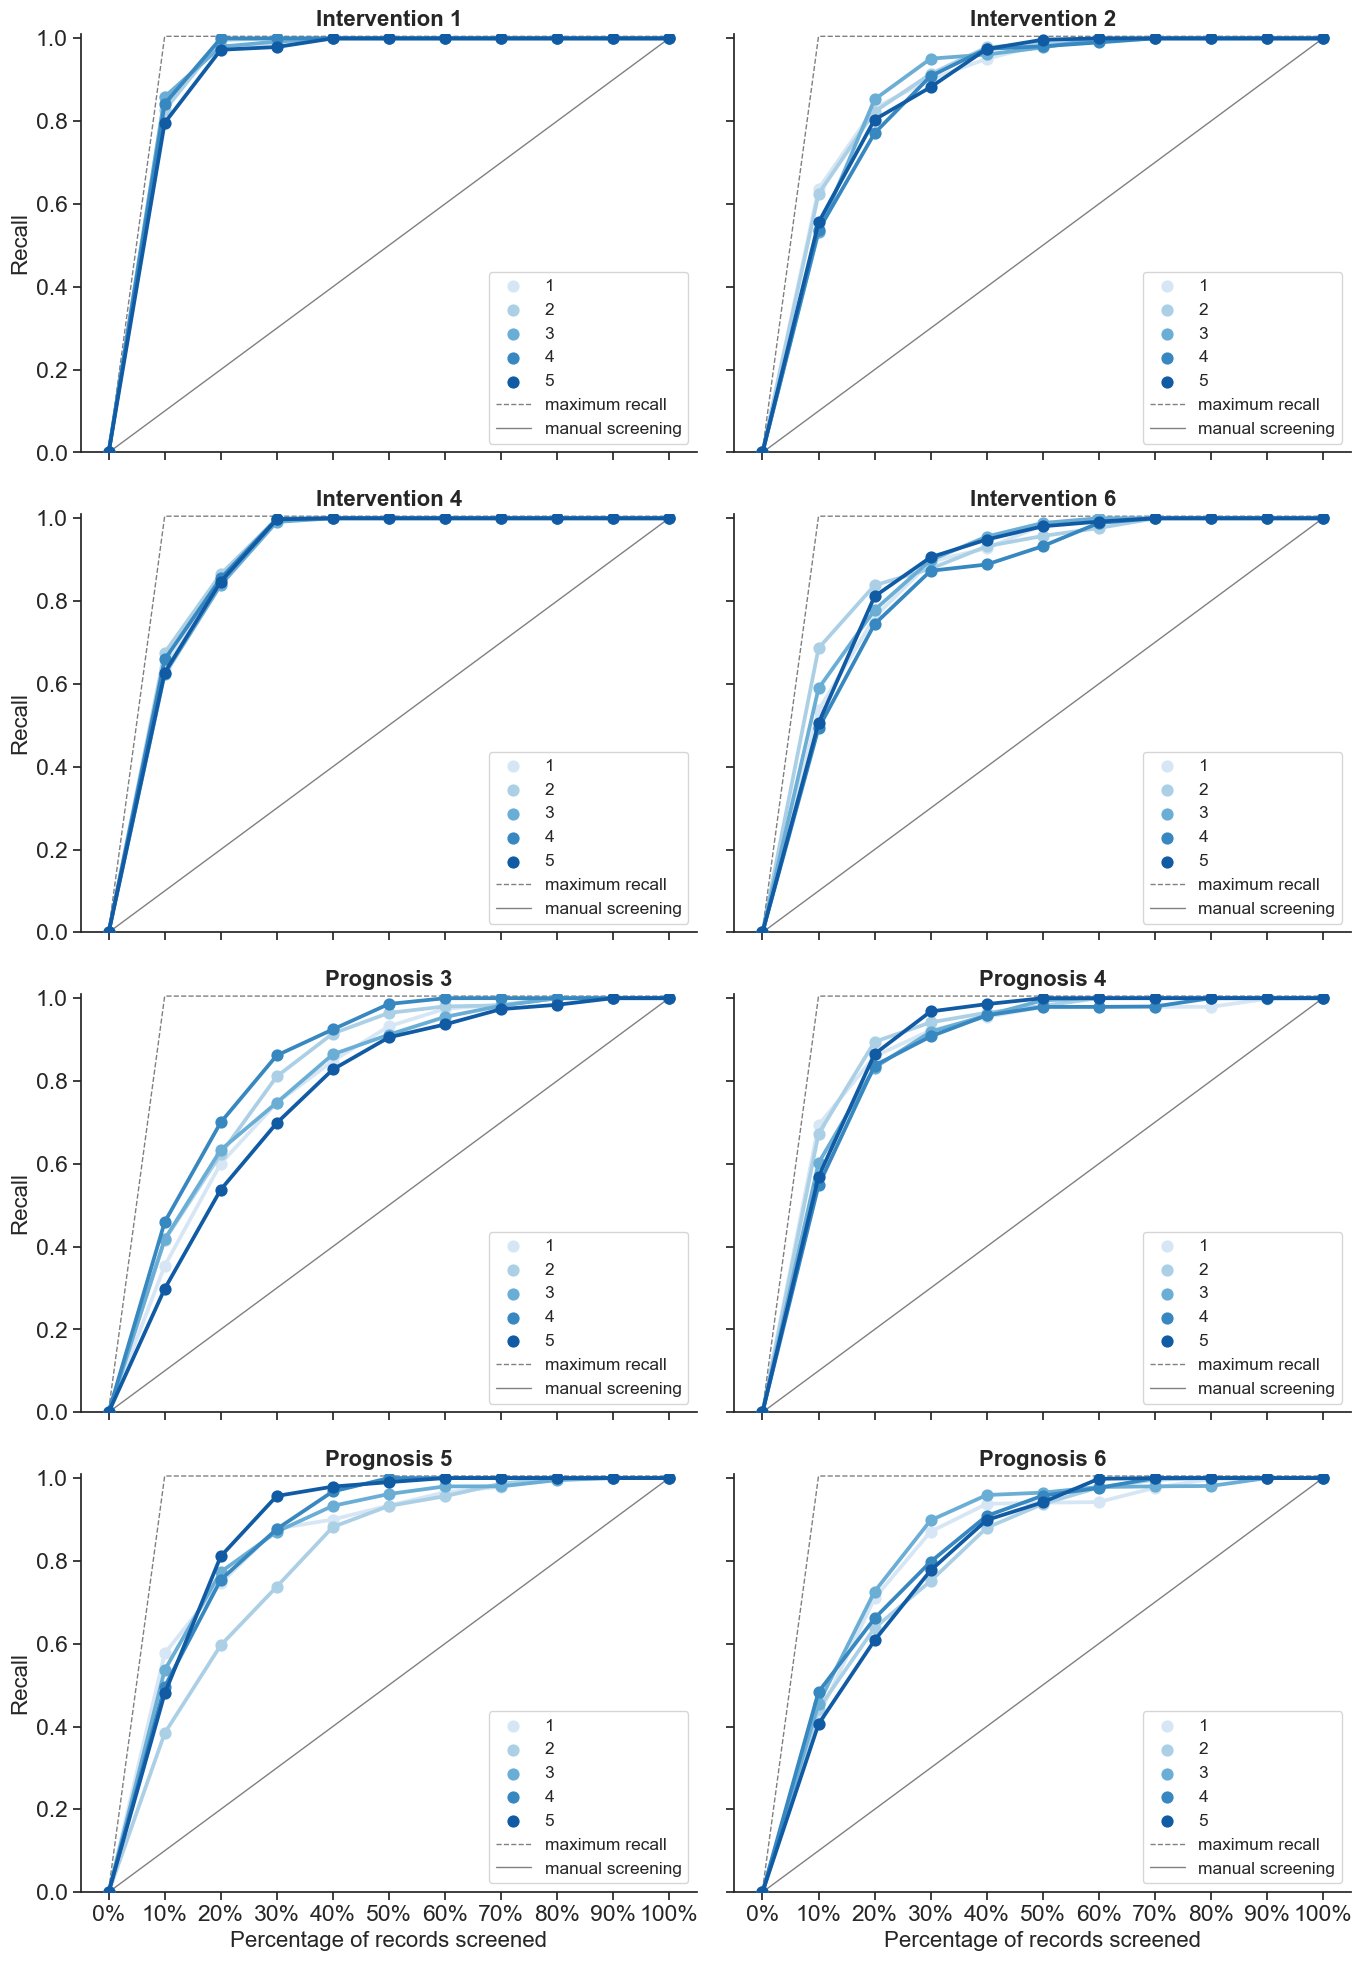

In [52]:
subset_reviews = ['500']
generate_lineplots(df_prop_sizes, df_max_recalls_sizes, subset_reviews)

### End